# *special* tutorial

Written by: *Valentin Christiaens*.

Last update: *2022/02/17*

## Table of contents

* [1. Loading the data](#1.-Loading-the-data)

* [2. Spectral correlation matrix](#2.-Spectral-correlation-matrix)
    - [2.1 Estimating the spectral correlation between IFS channels](#2.1-Estimating-the-spectral-correlation-between-IFS-channels)
    - [2.2 Concatenating spectral correlation matrices](#2.2-Concatenating-spectral-correlation-matrices)

* [3. Preliminary spectral analysis](#3.-Preliminary-spectral-analysis)
    - [3.1 Dereddening](#3.1-Dereddening)
    - [3.2 Spectral indices](#3.2-Spectral-indices)
    
* [4. MCMC sampler examples](#4.-MCMC-sampler-examples)
    - [4.1. Parameters](#4.1.-Parameters)
    - [4.2. Blackbody model](#4.2.-Blackbody-model)
    - [4.3. BT-SETTL model](#4.3.-BT-SETTL-model)
    - [4.4. BT-SETTL + BB model](#4.4.-BT-SETTL-+-BB-model)
    - [4.5. BT-SETTL + BrG line model](#4.5.-BT-SETTL-+-BrG-line-model)
    
* [5. Comparison of results](#5.-Comparison-of-results)
    - [5.1. Akaike Information Criterion](#5.1.-Akaike-Information-Criterion)
    - [5.2. Best-fit models](#5.2.-Best-fit-models)
    - [5.3. Models from the posterior distribution](#5.3.-Models-from-the-posterior-distribution)

* [6. Nested sampler examples](#6.-Nested-sampler-examples)
    - [6.1. Single ellipsoid method](#6.1.-Single-ellipsoid-method)
    - [6.2. Multi-ellipsoid method](#6.2.-Multi-ellipsoid-method)
* [7. Best-fit template spectrum](#7.-Best-fit-template-spectrum)

-----------

In [1]:
import special
special.__version__

'0.0.2'

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

# 1. Loading the data

In the 'dataset' folder of the `specfit_extras` repository you can find:

- a post-processed Integral Field Spectrograph (IFS) datacube (`CrA-9_2019_IFS_pca_annulus.fits`);
- the measured spectrum of (sub)stellar companion CrA-9 b/B (`CrA-9b_spectrum.fits`).

In the post-processed IFS cube, the emission from the central star has been modeled and subtracted using the ADI strategy in each spectral channel. The post-processing was performed using principal component analysis (PCA) applied in a single annulus. The annulus was chosen to encompass the faint (sub)stellar companion CrA-9b/B, which can be seen towards the left of the images.

Let's first inspect the IFS cube using the `info_fits` utility implemented in the `fits` module:

In [3]:
from special.fits import info_fits
info_fits('../datasets/CrA-9_2019_IFS_pca_annulus.fits')

Filename: ../datasets/CrA-9_2019_IFS_pca_annulus.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   (291, 291, 39)   float64   


The fits file contains an IFS datacube of 39 images with wavelengths spanning 0.95 to 1.68 $\mu$m.
Each image is 291x291 px across. Let's now open it and check a few spectral channels.

In [4]:
from special.fits import open_fits
ifs_cube = open_fits('../datasets/CrA-9_2019_IFS_pca_annulus.fits')

Fits HDU-0 data successfully loaded. Data shape: (39, 291, 291)


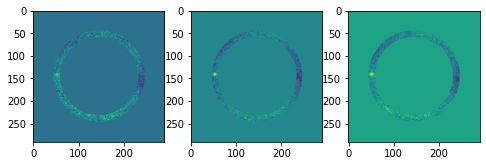

In [5]:
from special.config import figsize
fig, axes = plt.subplots(1,3,figsize=figsize)
axes[0].imshow(ifs_cube[1])
axes[1].imshow(ifs_cube[19])
axes[2].imshow(ifs_cube[-1])

A point source can be seen towards the left of the image. This is CrA-9 b/B, a faint companion to the pre-main sequence star CrA-9, whose nature is still debated (Christiaens et al. 2021). In addition to this IFS datacube obtained with VLT instrument SPHERE/IFS, three additional detections of the companion were obtained with VLT imagers SPHERE/IRDIS at 2.11 $\mu$m and 2.25$\mu$m, and NACO at 3.8 $\mu$m. The full measured spectrum contains thus 42 points: 

In [6]:
info_fits('../datasets/CrA-9b_spectrum.fits')

Filename: ../datasets/CrA-9b_spectrum.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (42, 4)   float32   


The 4 dimensions correspond to:

- the wavelength of each measurement (in $\mu$m); 
- the channel width (or FWHM of the broad band filter used in the case or IRDIS and NACO);
- the flux of the companion;
- the error on the flux.

In [7]:
spectrum_b = open_fits('../datasets/CrA-9b_spectrum.fits')

lbda = spectrum_b[0]
dlbda = spectrum_b[1]
spec = spectrum_b[2]
spec_err = spectrum_b[3]

Fits HDU-0 data successfully loaded. Data shape: (4, 42)


The flux units follow the SI convention (W m$^{-2}$). Let's set it for later. Note that `specfit` can also handle 'cgs' and 'jy'. The relevant conversions will be made internally if units are provided for observed and model spectra. If not specified, `specfit` assumes SI units.

In [8]:
units_obs = 'si'

Let's visualize the measured spectrum in $\lambda F_{\lambda}$ units:

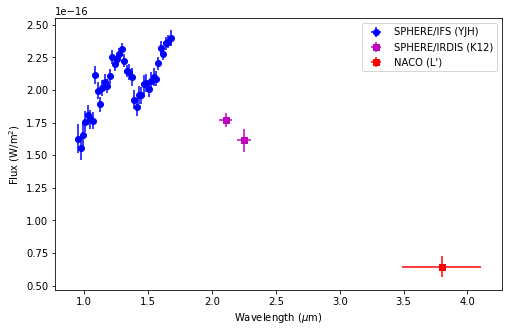

In [9]:
fig = plt.figure(figsize=figsize)
plt.errorbar(lbda[:-3], lbda[:-3]*spec[:-3], lbda[:-3]*spec_err[:-3], dlbda[:-3], 'bo', 
             label = 'SPHERE/IFS (YJH)')
plt.errorbar(lbda[-3:-1], lbda[-3:-1]*spec[-3:-1], lbda[-3:-1]*spec_err[-3:-1], dlbda[-3:-1], 'ms', 
             label = 'SPHERE/IRDIS (K12)')
plt.errorbar(lbda[-1], lbda[-1]*spec[-1], lbda[-1]*spec_err[-1], dlbda[-1], 'rs', 
             label = "NACO (L')")
plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel(r"Flux (W/m$^2$)")
plt.legend()

[Go to the top](#Table-of-contents)

# 2. Spectral correlation matrix

## 2.1 Estimating the spectral correlation between IFS channels

Before fitting different models to the spectrum, let's first estimate the spectral correlation between the IFS channels. By design of the IFS, the flux at a given wavelength leaks on/overlaps with neighbouring channels. These can therefore not be considered as independent measurements. The spectral correlation matrix has therefore to be considered when fitting a given IFS spectrum. Not taking it into account can indeed lead to significant biases, and in particular to erroneous results in terms of best-fit model parameters (see e.g. Greco & Brant 2017). 

Estimating the spectral correlation can be done easily in `specfit` using the `spectral_correlation` routine, which follows the method recommended in Greco & Brandt (2017). For that let's first determine the location of the companion in the IFS images, by zooming on the median image of the cube:

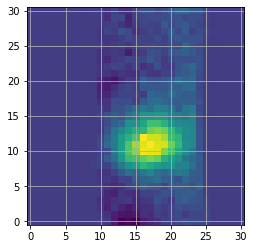

In [10]:
x_i = 35
y_i = 130
sz = 31
plt.imshow(np.median(ifs_cube,axis=0)[y_i:y_i+sz,x_i:x_i+sz])
plt.gca().invert_yaxis()
plt.grid()

Based on the above inset, we can set the approximate coordinates of the companion, and infer its radial separation:

In [11]:
pl_xy = ((x_i+17,y_i+11),) # set pl_xy as a tuple of 2-element tuples - each tuple corresponds to a different companion

cy = (ifs_cube.shape[1]/2.)-0.5
cx = (ifs_cube.shape[2]/2.)-0.5
r0 = np.sqrt((pl_xy[0][0]-cx)**2+(pl_xy[0][1]-cy)**2)
r0

93.08598175880189

The spectral correlation depends on the radial separation to the central star. The algorithm implemented in `specfit` can therefore compute it in concentric annuli between given inner and outer radii (by default spanning the whole field). Here since we are only interested in the spectral correlation at the radial separation of the companion, let's set the annular width, inner and outer radii such that they only encompass the companion radial separation:


In [12]:
awidth=2
r_in = int(r0-awidth/2)
r_out = int(r0+awidth/2)

Furthermore, we mask the area around the companion to not bias the spectral correlation estimate with companion flux. We set the mask radius to be 4 times the FWHM, with a FWHM set to 4px:


In [13]:
mask_r=4
fwhm=4

Now, we can estimate the spectral correlation at the radial separation of CrA-9b/B:

In [14]:
from special.spec_corr import spectral_correlation
sp_corr = spectral_correlation(ifs_cube, awidth=awidth, r_in=r_in, r_out=r_out, pl_xy=pl_xy, 
                               mask_r=mask_r, fwhm=fwhm)
sp_corr = sp_corr[0]

Let's visualize it:

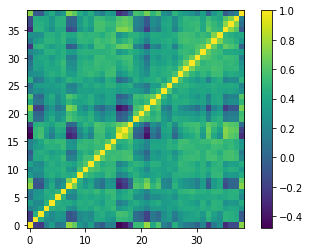

In [15]:
plt.imshow(sp_corr)
plt.colorbar()
plt.gca().invert_yaxis()

We see that, as expected, each spectral channel is most correlated to itself, and at most to its 2 closest neighbouring channels. Depending on the number of principal components (npc) subtracted during the PCA, a stronger (low npc) or lower (high npc) residual correlation will be seen between adjacent channels.

## 2.2 Concatenating spectral correlation matrices

Since our full spectrum of CrA-9b/B also contains photometric points measured by SPHERE/IRDIS (2) and NACO (1), we need to pad the IFS spectral correlation matrix with 3 additional rows and columns of zeroes + ones on the diagonal, in order to get the final spectral correlation matrix.

This can easily be done with the `combine_spec_corrs` routine:

In [16]:
from special.utils_spec import combine_spec_corrs

n_ird=2
n_naco=1
arr_list = [sp_corr]+[1]*n_ird+[1]*n_naco

final_sp_corr = combine_spec_corrs(arr_list)

Let's visualize the final matrix:

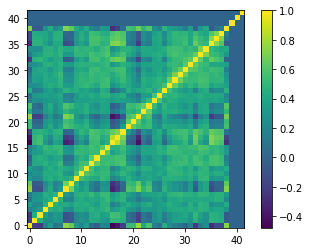

In [17]:
plt.imshow(final_sp_corr)
plt.colorbar()
plt.gca().invert_yaxis()

Uncomment the lines in the following box if you wish to save the final spectral correlation matrix in fits format.

In [18]:
#from special.fits import write_fits
#write_fits("../datasets/CrA-9_sp_corr_matrix.fits", final_sp_corr)

[Go to the top](#Table-of-contents)

# 3. Preliminary spectral analysis

A number of utilities are implemented in the `utils_spec` module, which allow for a preliminary qualitative analysis of the spectrum of the companion. However, to avoid biased conclusions due to extinction in this preliminary analysis, let's first deredden the observed spectrum using the value quoted in the literature for CrA-9 ($A_V = 1.6$ mag; Dunham et a. 2015).

## 3.1 Dereddening

Provided a given $A_V$ extinction value, the `extinction` routine can estimate the corresponding extinction factor at different wavelengths following the Cardelli et al. (1989) law, and for a desired $R_V$ value. Let's consider the standard ISM value of $R_V = 3.1$ mag (default if not provided).

In [19]:
from special.utils_spec import extinction
AV_est = 1.6 #mag
A_lambda = extinction(lbda, AV_est, RV=3.1)
extinc_fac = np.power(10,-A_lambda/2.5)

Let's plot the extinction factor as a function of wavelength:

Text(0, 0.5, 'Extinction factor')

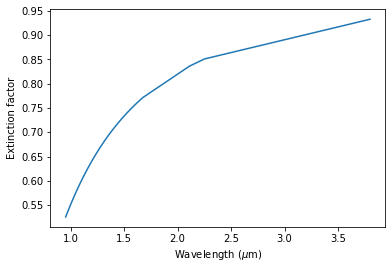

In [20]:
plt.plot(lbda, extinc_fac)
plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel(r"Extinction factor")

We see that as expected the effect of extinction is stronger at shorter NIR wavelengths: at 1.0 $\mu$m roughly only half of the flux is transmitted, while at $L'$ band (3.8 $\mu$m) $\sim$ 93\% of the flux is transmitted.

Let's now deredden the spectrum accordingly and plot it:

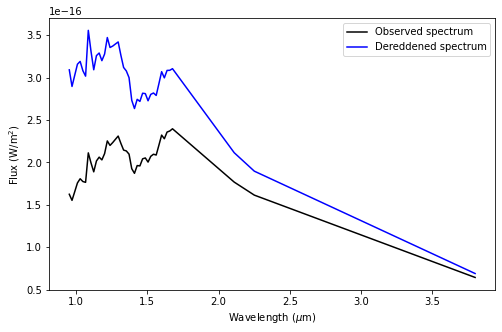

In [21]:
spec_dered = spec/extinc_fac
spec_dered_err = spec_err/extinc_fac

fig = plt.figure(figsize=figsize)
plt.plot(lbda, lbda*spec, 'k', label="Observed spectrum")
plt.plot(lbda, lbda*spec_dered, 'b', label="Dereddened spectrum")
plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel(r"Flux (W/m$^2$)")
plt.legend()

## 3.2 Spectral indices

(Sub)stellar objects of M, L and T types have been extensively studied, such that some empirical spectral indices. Some standard spectral indices have been included in `specfit`. An example is provided below with the H$_2$O and Na indices which are relevant for a $YJH$ spectrum.

It is important to note that different spectral indices are valid in different spectral subtype ranges! The interested reader is referred to the following works: Allers et al. (2007); Bonnefoy et al. (2014) and references therein.

In [22]:
from special.spec_indices import spectral_idx

H2O_idx = spectral_idx(lbda, spec_dered, 'H2O-1.5', spec_dered_err, verbose=True)
Na_idx = spectral_idx(lbda, spec_dered, 'Na-1.1', spec_dered_err, verbose=True)
        
print("***********************")
print("H2O index: ",H2O_idx)
print("Na index: ",Na_idx)
print("***********************")

Closest indices to 1.55, 1.56, 1.492 and 1.502 mucorrespond to 1.5436315536499023, 1.562684178352356, 1.4864736795425415 and 1.5055263042449951 resp.
Closest indices to 1.15, 1.16, 1.134 and 1.144 mucorrespond to 1.143526315689087, 1.1625789403915405, 1.1244736909866333 and 1.143526315689087 resp.
***********************
H2O index:  (0.9753922, 0.0068133129230896474)
Na index:  (1.0142473, 0.007491888724907396)
***********************


The H$_2$O index can then be converted to an estimated spectral type:

In [23]:
from special.spec_indices import sp_idx_to_spt, idx_to_spt

spt, spt_err = sp_idx_to_spt(H2O_idx[0], 'H2O-1.5', H2O_idx[1])
spt_str = idx_to_spt(spt, convention='Allers07')
print("SpT: {}+-{:.1f}".format(spt_str, spt_err))

SpT: M5.1+-0.8


The Na index on the other hand can be used to estimate the gravity (hence the youth) of an object:

In [24]:
if Na_idx[0] < 1.4:
    print("The object's gravity is consistent with being very young (Na index less than 1.4)")
else:
    print("The Na index does not suggest a very low gravity (i.e. it is unlikely to be very young)")

The object's gravity is consistent with being very young (Na index less than 1.4)


[Go to the top](#Table-of-contents)

# 4. MCMC sampler examples

Now let's fit different models to the observed spectrum of CrA-9 b/B.

In that purpose, let's first define some parameters that will be common to all MCMC sampler runs on this measured spectrum.

## 4.1. Parameters

Let's first define the distance to the system, which will be used to scale the models (along with the companion radius):

In [25]:
d_st = 153. #pc based on Gaia

The internal workings of `specfit` allow for the convolution with the spectral PSF of (in the case of an IFS), or the integration over a filter transmission curve (in the case of photometric points). For these options to be considered, let's provide the nominal spectral FWHM in nm for IFS (19.15 nm), and the name of the filenames where the filter transmission curves are encoded. 

In [26]:
instru_fwhm = [19.15, #when a float is provided, should be in nm
               'SPHERE_IRDIS_D_K1.dat',
               'SPHERE_IRDIS_D_K2.dat',
               'CONICA_L_prime.dat']

Now let's assign an index to each instrument and build a list that will tell the algorithm which instru_fwhm_nm values are to be assigned to which datapoints.

In [27]:
n_ifs=39
instru_idx = np.array(n_ifs*[1]+[2]+[3]+[4])  

In addition, we define a snippet function that can read the filter transmissions mentioned in the list. For convenience (and to allow for multiprocessing), it is defined in `utils.py`, and commented below FYI.

In [28]:
from utils import filter_reader

# import pandas as pd
# def filter_reader(filename):
#     # snippet to read filter files and return a tuple: lbda (mu), transmission
#     filter_path = "../static/filters/"
#     filt_table = pd.read_csv(filter_path+filename, sep=' ', header=0, 
#                              skipinitialspace=True)
#     keys = filt_table.keys()
#     lbda_filt = np.array(filt_table[keys[0]])
#     if lbda_filt.dtype == 'O':
#         filt_table = pd.read_csv(filter_path+filename, sep='\t', header=0, 
#                                  skipinitialspace=True)
#         keys = filt_table.keys()
#         lbda_filt = np.array(filt_table[keys[0]])
#     elif lbda_filt.dtype == 'int32' or lbda_filt.dtype == 'int64': 
#         lbda_filt = np.array(filt_table[keys[0]], dtype='float64')
#     if '(AA)' in keys[0]:
#         lbda_filt /=10000
#     elif '(mu)' in keys[0]:
#         pass
#     elif '(nm)' in keys[0]:
#         lbda_filt /=1000
#     else:
#         raise ValueError('Wavelength unit not recognised in filter file')
#     trans = np.array(filt_table[keys[1]])
#     return lbda_filt, trans

Let's assemble all parameters related to the instrument(s) and filter(s) into a dictionary, including as well the spectral correlation calculated in Sec. 2:

In [29]:
instru_params = {'instru_fwhm':instru_fwhm,
                 'instru_idx':instru_idx,
                 'instru_corr': final_sp_corr,
                 'filter_reader': filter_reader}

`specfit` was implemented with directly imaged substellar objects in mind. Radii and masses therefore implicitly assume Jovian units. If you prefer Solar radii for your outputs, set `star` to True in the following box:

In [30]:
from astropy import constants as c

star = False # whether use Solar units
if star:
    conv_RS = c.R_jup/c.R_sun
    conv_RS

Let's set the MCMC parameters identically for all runs shown in the next subsections (see more details in `emcee` documentation):

In [31]:
a=2.0
nwalkers=100
niteration_min=100
niteration_limit=500 # recommended>> 1000
nproc = 2            # number of CPUs

mcmc_params = {'a':a,
               'nwalkers':nwalkers,
               'niteration_min':niteration_min,
               'niteration_limit':niteration_limit,
               'nproc':nproc}

Similarly, we adopt the autocorrelation time criterion for convergence for all MCMC runs (see more details [here](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/)):

In [32]:
conv_test='ac'
ac_c=50
ac_count_thr=1

conv_params = {'conv_test': conv_test,
               'ac_c': ac_c,
               'ac_count_thr':ac_count_thr}

Note that for the purpose of this tutorial, we set a low number of walkers and a low maximum number of iterations. It is recommended to set it large enough (>>1000, depends on number of parameters and model) such that the convergence criterion will break the chain once it is met.

## 4.2. Blackbody model

This model does not involve any grid:

In [33]:
grid_list=None # triggers a blackbody fit

The 2 parameters are the temperature and radius (of a sphere). It is important to label the blackbody temperature and radius 'Tbb1' and 'Rbb1', respectively. This is because `specfit` allows for the addition of an unlimited number of blackbody components. E.g. for n components, set the labels from 'Tbb1' to 'Tbbn' and from 'Rbb1' to 'Rbbn'. 

In [34]:
labels = ('Tbb1', 'Rbb1')
units = ('K', r'$R_J$')

npar = len(labels)

Set the initial guesses and bounds accordingly. Note the requirement for a Jovian input radius.

In [35]:
ini_guess = (3200., 1.3) #K and R_Jup
bounds = {'Tbb1':(2000,4000), 
          'Rbb1':(0.1,5)}

Again, let's collate all model-related parameters into a dictionary:

In [36]:
model_params={'grid_param_list':grid_list,
              'labels':labels,
              'initial_state':ini_guess,
              'bounds':bounds}

Now let's run the MCMC sampler (**Warning: the next cell may take a few minutes to complete**):

In [37]:
from special.mcmc_sampling import mcmc_spec_sampling

res = mcmc_spec_sampling(lbda, spec, spec_err, d_st, dlbda_obs=dlbda, units_obs=units_obs,
                         **instru_params, **mcmc_params, **conv_params, **model_params)

Let's convert the sampled radii into Solar radii:

In [38]:
final_chain, ln_proba = res
if star:
    idx_R = labels.index('Rbb1')
    final_chain[:,:,idx_R] = final_chain[:,:,idx_R].copy()*conv_RS
    # change units of radius
    units = list(units)
    units[-1] = r'$R_{\odot}$'
    units = tuple(units)

Let's inspect the walk plot:

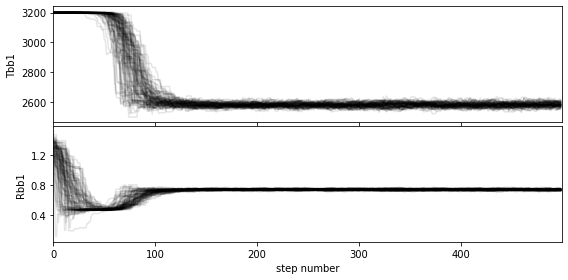

In [39]:
from special.mcmc_sampling import show_walk_plot

show_walk_plot(final_chain, labels)#, save=False,# output_dir='../datasets/',

If you wish to save the walk plot in a pdf, set `save=True` and provide a value for the output directory (`output_dir`).

Based on the walk plot, let's define a conservative burnin factor of 0.3 and apply it to the chain:

In [40]:
burnin=0.3

In [41]:
cutoff = int(final_chain.shape[1]//(1/burnin))
ngood_steps = final_chain.shape[1]-cutoff
samples_flat_BB = final_chain[:, cutoff:, :].reshape((-1,npar)) 
#write_fits(output_dir+"isamples_flat.fits",isamples_flat)

Let's compute the 68.27% confidence intervals on the posterior distribution, after burnin:

percentage for Tbb1: 68.71142857142858%
percentage for Rbb1: 69.58000000000001%
******* Results for Tbb1 ***** 


Confidence intervals:
Tbb1: 2577.579857662716 [-12.494052536269919,18.443601363065227]
******* Results for Rbb1 ***** 


Confidence intervals:
Rbb1: 0.7396492456553482 [-0.01064568719877168,0.009177316550665116]


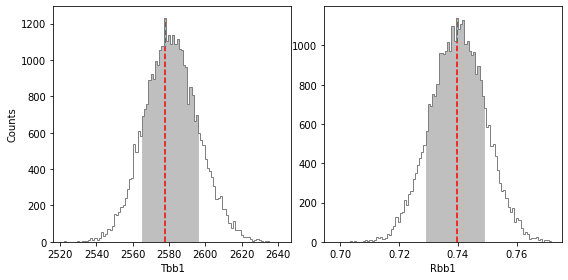

In [42]:
from special.mcmc_sampling import confidence

bins = 100
vals, err = confidence(samples_flat_BB, labels, cfd=68.27, bins=bins, 
                            gaussian_fit=False, weights=None, 
                            verbose=True, save=False, bounds=bounds, 
                            priors=None)

If you wish to save the results in a text file, set `save=True` and provide a value for the output directory (`output_dir`).

Let's define the most likely parameters along with their uncertainties in a numpy array:

In [43]:
post_params = np.zeros([npar,3])
for i in range(npar):
    post_params[i,0] = vals[labels[i]]
    post_params[i,1] = err[labels[i]][0]    
    post_params[i,2] = err[labels[i]][1]

Now, let's have a look at the corner plot. A couple of parameters can be fine tuned for aesthetics, e.g.:

- number of significant digits for each parameter (`ndig`), 
- labels to be used in the plot for each parameter (`labels_plot` can be different to the string used in `labels` but `labels` is used if not provided), 
- font attributes for plot title and label, 
- number of bins to consider for the corner plot histograms.

In [44]:
ndig = (0,2) # should have same length as labels
labels_plot = (r'$T$', r'$R$')
title_kwargs={"fontsize": 16}
label_kwargs={"fontsize": 16}
corner_bins = 20

If you wish to save the corner plot in pdf format, set `save=True` and provide a value to `plot_name`.

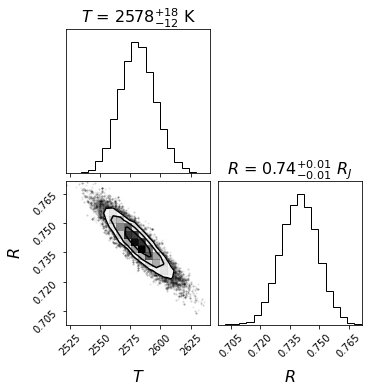

In [45]:
from special.mcmc_sampling import show_corner_plot

#note: provide the chain before burnin, since burnin is done internally here:
show_corner_plot(final_chain, burnin=burnin, save=False,  
                      mcmc_res=post_params, units=units, ndig=ndig, labels_plot=labels_plot,
                      labels=labels, #plot_name='corner_plot.pdf',
                      title_kwargs=title_kwargs, label_kwargs=label_kwargs, bins=corner_bins)

As expected, the 2 parameters are highly dependent on each other. With only 2 parameters, we also note that the estimated uncertainties on each parameter are very small. As we will see, with a more realistic model including more parameters, the uncertainties on each parameter widens.

Let's save the likelihood and parameter values of the most likely model for later ([Sec. 5.2](#5.2.-Best-fit-models)):

In [46]:
# favoured model has highest likelihood
max_prob_BB = np.nanmax(ln_proba)
idx_max = np.unravel_index(np.nanargmax(ln_proba),shape=ln_proba.shape)
bf_params_BB = final_chain[idx_max]
bf_params_BB

array([2.58128969e+03, 7.39761626e-01])

## 4.3. BT-SETTL model

Let's now consider a grid of BT-SETTL models. In addition, let's also consider extinction as a free parameter, since for young objects it is possible that different amounts of dust surround the companion than the central star.

In the case of BT-SETTL models, there are 2 free parameters in the grid: effective temperature and surface gravity. Let's define the grid of parameter values covered by the models in our possession (in the `models/btsettl15/` directory).

In [47]:
teff_list = np.linspace(2000,4000,num=21).tolist()
logg_list = np.linspace(2.5,5.5,num=7).tolist()
grid_list = [teff_list, logg_list]

Let's now define a snippet function that can read the input files of the grid, and provide as output a tuple of 2 vectors (1d arrays) for the wavelength and flux (in SI units, at the surface of the object). For convenience (and to allow for multiprocessing), it is defined in `utils.py`, and commented below FYI.

In [48]:
from utils import bts_reader
# def bts_reader(params):
#     # snippet to read BT-SETTL fits files and return a tuple: lbda (mu), spec (SI)
#     mod_units = 'cgs' # careful: input in cgs
#     mod_path = '../static/btsettl15_models/'
#     filename = mod_path+'btsettl15_t{:.0f}_g{:.1f}0_z-0.00_SPEX-PRISM.txt'.format(params[0],params[1])        
#     lbda = []
#     flux = []
#     f=open(filename,"r")
#     lines=f.readlines()
#     for i, x in enumerate(lines):
#         if i>0:
#             lbda.append(float(x.split('\t')[0]))
#             flux.append(float(x.split('\t')[1]))
#     f.close() 
    
#     # Correct for atmospheric refraction
#     flux = np.array(flux) 
#     lbda = np.array(lbda)
#     nref = nrefrac(lbda*1e4)
#     lbda = lbda/(1+(nref*1e-6))
    
#     #conversion from ergs/s/cm2/um to W/m2/um
#     flux = convert_F_units(flux, lbda, in_unit=mod_units, out_unit='si') 
    
#     return lbda, flux

Since the snippet function already performs the conversion to SI flux units (W m$^{-2}$), we will the model units to 'si'. Note that 'cgs' units or 'jy' are also accepted - the conversion to match the observed flux would then be made internally.

In [49]:
units_mod = 'si'

Considering also the extinction `A_V` as a free parameter, we have a total of 4 free parameters, including 2 captured by the grid:

The 2 parameters are the temperature and radius (of a sphere). It is important to label the blackbody temperature and radius 'Tbb1' and 'Rbb1', respectively. This is because `specfit` allows for the addition of an unlimited number of blackbody components. E.g. for n components, set the labels from 'Tbb1' to 'Tbbn' and from 'Rbb1' to 'Rbbn'. 

In [50]:
labels = ('Teff', 'logg', 'R', 'Av')
units = ('K', '', r'$R_J$', 'mag')

npar = len(labels)

Set the initial guesses and bounds accordingly. Note the requirement for a Jovian input radius.

In [51]:
ini_guess = (3100., 3.5, 1.3, 1.6)
bounds = {'Teff':(2000,4000), 
          'logg':(2.5,5.5), 
          'R':(0.1,5), 
          'Av':(0.,5)}

In [52]:
model_params={'grid_param_list':grid_list,
              'model_reader':bts_reader,
              'labels':labels,
              'initial_state':ini_guess,
              'bounds':bounds,
              'units_mod':units_mod}

In order for the MCMC sampler to run faster, all models of the grid are first resampled (at the same sampling as the measured spectrum), such that only light spectra files are opened and interpolated during the sampling. To do so, set `resamp_before=True` and provide a path and name where the resampled grid will be saved:

In [53]:
grid_name='bts_resamp_grid.fits' 
output_dir='../static/bts_output/'
resamp_before=True

**Important**: if a file named `output_dir`+`grid_name` already exists it will be used, instead of creating a new resmpled grid (this is to save time when a given MCMC sampling is performed multiple times with different options). Make sure to change either `output_dir` or `grid_name` when considering different models or a different range of parameter values in the grid (i.e. differente `grid_list`).

We also set a filename where the MCMC results will be written as a pickle, such that they can be accessed without having to run again the MCMC.

In [54]:
output_file = 'MCMC_results' # also written in output_dir

output_params = {'resamp_before':resamp_before,
                 'grid_name':grid_name,
                 'output_dir': output_dir,
                 'output_file': output_file}

Now let's run the MCMC sampler (**Warning: the next cell may take a few minutes to complete**):

In [55]:
from special.mcmc_sampling import mcmc_spec_sampling

res = mcmc_spec_sampling(lbda, spec, spec_err, d_st, dlbda_obs=dlbda, 
                                      **instru_params, **mcmc_params, **conv_params,
                                      **model_params, **output_params)

Fits HDU-0 data successfully loaded. Data shape: (21, 7, 42, 2)


In [56]:
final_chain, ln_proba = res
if star:
    idx_R = labels.index('R')
    final_chain[:,:,idx_R] = final_chain[:,:,idx_R].copy()*conv_RS
    # change units of radius
    units = list(units)
    units[-1] = r'$R_{\odot}$'
    units = tuple(units)

Let's inspect the walk plot:

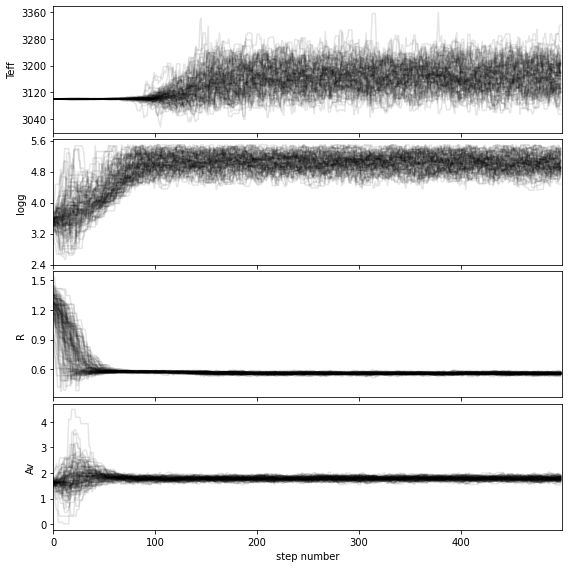

In [57]:
from special.mcmc_sampling import show_walk_plot

show_walk_plot(final_chain, labels)#, save=False,# output_dir='../datasets/',

If you wish to save the walk plot in a pdf, set `save=True` and provide a value for the output directory (`output_dir`).

Based on the walk plot, let's define a conservative burnin factor of 0.3 and apply it to the chain:

In [58]:
burnin=0.3

In [59]:
cutoff = int(final_chain.shape[1]//(1/burnin))
ngood_steps = final_chain.shape[1]-cutoff
samples_flat_BTS = final_chain[:, cutoff:, :].reshape((-1,npar)) 
#write_fits(output_dir+"isamples_flat.fits",isamples_flat)

Let's compute the 68.27% confidence intervals on the posterior distribution, after burnin:

percentage for Teff: 69.18571428571428%
percentage for logg: 69.32857142857142%
percentage for R: 70.02285714285715%
percentage for Av: 69.22571428571428%
******* Results for Teff ***** 


Confidence intervals:
Teff: 3171.853870983539 [-52.99202903035393,36.93383841509558]
******* Results for logg ***** 


Confidence intervals:
logg: 5.021700355779273 [-0.20654777963736226,0.25375870069732986]
******* Results for R ***** 


Confidence intervals:
R: 0.5585898417139835 [-0.008484523467428784,0.011716722883592268]
******* Results for Av ***** 


Confidence intervals:
Av: 1.8101018478203634 [-0.1005974850343283,0.05416787655694599]


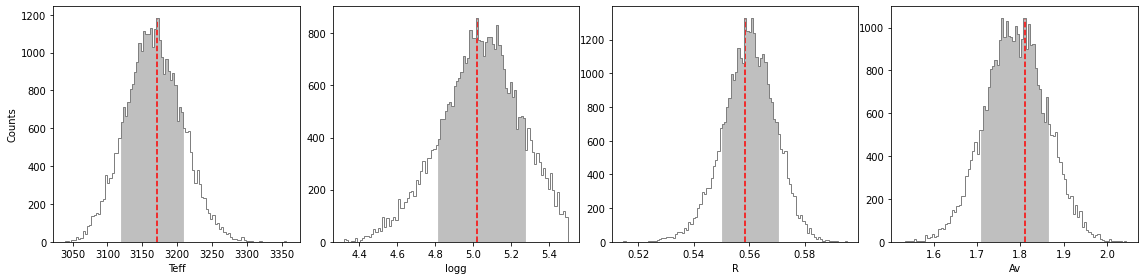

In [60]:
from special.mcmc_sampling import confidence

bins = 100
vals, err = confidence(samples_flat_BTS, labels, cfd=68.27, bins=bins, 
                            gaussian_fit=False, weights=None, 
                            verbose=True, save=False, bounds=bounds, 
                            priors=None)

If you wish to save the results in a text file, set `save=True` and provide a value for the output directory (`output_dir`).

Let's define the most likely parameters along with their uncertainties in a numpy array:

In [61]:
post_params = np.zeros([npar,3])
for i in range(npar):
    post_params[i,0] = vals[labels[i]]
    post_params[i,1] = err[labels[i]][0]    
    post_params[i,2] = err[labels[i]][1]

Now, let's have a look at the corner plot. A couple of parameters can be fine tuned for aesthetics, e.g.:

- number of significant digits for each parameter (`ndig`), 
- labels to be used in the plot for each parameter (`labels_plot` can be different to the string used in `labels` but `labels` is used if not provided), 
- font attributes for plot title and label, 
- number of bins to consider for the corner plot histograms.

In [62]:
ndig = (0,1,2,1) # should have same length as labels
labels_plot = (r'$T$', r'log($g$)', r'$R$',  r'$A_V$')
title_kwargs={"fontsize": 16}
label_kwargs={"fontsize": 16}
corner_bins = 20

If you wish to save the corner plot in pdf format, set `save=True` and provide a value to `plot_name`.

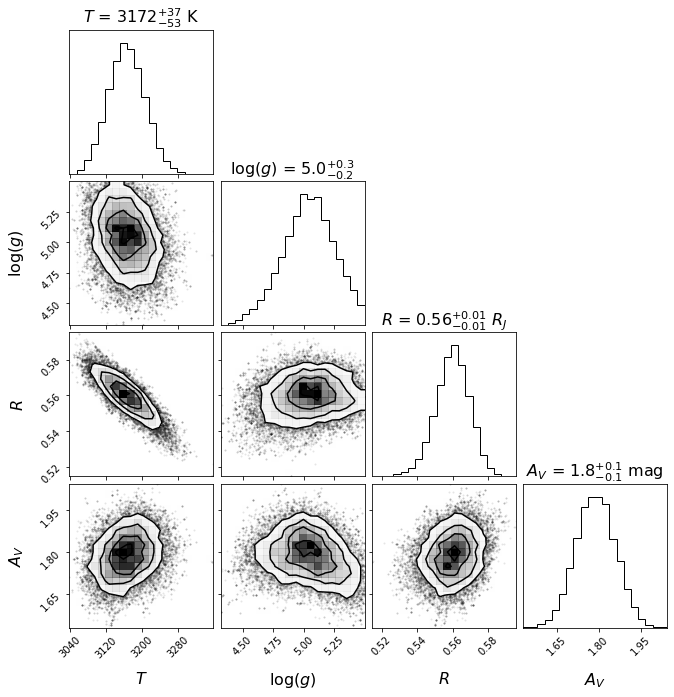

In [63]:
from special.mcmc_sampling import show_corner_plot

#note: provide the chain before burnin, since burnin is done internally here:
show_corner_plot(final_chain, burnin=burnin, save=False,  
                      mcmc_res=post_params, units=units, ndig=ndig, labels_plot=labels_plot,
                      labels=labels, #plot_name='corner_plot.pdf',
                      title_kwargs=title_kwargs, label_kwargs=label_kwargs, bins=corner_bins)

Let's save the likelihood and parameter values of the most likely model for later ([Sec. 5.2](#5.2.-Best-fit-models)):

In [64]:
# favoured model has highest likelihood
max_prob_BTS = np.nanmax(ln_proba)
idx_max = np.unravel_index(np.nanargmax(ln_proba),shape=ln_proba.shape)
bf_params_BTS = final_chain[idx_max]
bf_params_BTS

array([3.16633525e+03, 5.00426271e+00, 5.62017189e-01, 1.81206806e+00])

The results above are puzzling: a ~3000 K effective temperature combined with a ~0.5 $R_J$ photometric radius. See Christiaens et al. (2021) for a discussion on the different hypotheses put forward to reconcile these results.

## 4.4. BT-SETTL + BB model

Although this is not necessarily a good model for the NIR spectrum of CrA-9 B/b, let's illustrate how to set up a photospheric + extra blackbody component model to further showcase the possibilities available in `specfit`.

Let's set Gaussian priors on the temperatures of each Blackbody component, to replicate the kinds of constraints that could potentially be obtained from past works.

Note that a single extra BB component is considered here, but `specfit` does not limit the number of components you wish to incorporate in the model (just add the desired number of parameters 'Tbb*n*' and 'Rbb*n*', where *n*>0).

This time, we have a total of 8 free parameters, including 2 captured by the BT-SETTL grid:

In [65]:
labels = ('Teff', 'logg', 'R', 'Av', 'Tbb1', 'Rbb1')
units = ('K', '', r'$R_J$', 'mag', 'K', r'$R_J$')
npar = len(labels)

teff_list = np.linspace(2000,4000,num=21).tolist()
logg_list = np.linspace(2.5,5.5,num=7).tolist()
grid_list = [teff_list, logg_list]

Set the initial guesses and bounds accordingly. Note the requirement for a Jovian input radius.

In [66]:
ini_guess = (3100., 3.5, 1.3, 1.6, 1100, 1)
bounds = {'Teff':(2000,4000), 
          'logg':(2.5,5.5), 
          'R':(0.1,5), 
          'Av':(0.,5),
          'Tbb1':(900,2000),
          'Rbb1':(0.1,5)}

Let's set Gaussian priors for log($g$), $T_{bb1}$ and $T_{bb2}$ in a dictionary. By default, uniform priors are considered for parameters not mentioned in this dictionary. Be sure to use the same dictionary labels as for parameter `labels`.

In [67]:
priors = {'logg':(3.5,0.2),
          'Tbb1':(1200,200)}

When including a blackbody component, you can ensure that the sampled solutions are physical (e.g. the BB temperatures must systematically be lower temperature than the photosphere effective temperature - assuming it comes from surrounding heated dust):

In [68]:
physical=True

It is also possible to tell the model whether to apply the extinction before or after adding the blackbody component, depending on where the dust absorbing the companion signal is to be assumed with respect to the emitting dust. By default, we assume the latter (e.g. interstellar dust).

In [69]:
AV_bef_bb = False

Let's compile all model-related parameters defined above into a dictionary:

In [70]:
model_params={'grid_param_list':grid_list,
              'model_reader':bts_reader,
              'labels':labels,
              'initial_state':ini_guess,
              'bounds':bounds,
              'priors':priors,
              'units_mod':units_mod,
              'physical':physical,
              'AV_bef_bb':AV_bef_bb}

In order for the MCMC sampler to run faster, all models of the grid are first resampled (at the same sampling as the measured spectrum), such that only light spectra files are opened and interpolated during the sampling. To do so, set `resamp_before=True` and provide a path and name where the resampled grid will be saved:

In [71]:
grid_name='bts_bb_resamp_grid.fits' 
output_dir='../static/bts_output/'
resamp_before=True

**Important**: if a file named `output_dir`+`grid_name` already exists it will be used, instead of creating a new resmpled grid (this is to save time when a given MCMC sampling is performed multiple times with different options). Make sure to change either `output_dir` or `grid_name` when considering different models or a different range of parameter values in the grid (i.e. different `grid_list`).

We also set a filename where the MCMC results will be written as a pickle, such that they can be accessed without having to run again the MCMC.

In [72]:
output_file = 'MCMC_results_bb' # also written in output_dir

output_params = {'resamp_before':resamp_before,
                 'grid_name':grid_name,
                 'output_dir': output_dir,
                 'output_file': output_file}

Finally, given the larger number of parameters, let's increase the number of iterations and walkers:

In [73]:
a=2.0
nwalkers=200
niteration_min=100
niteration_limit=1000 # recommended>> 1000
nproc = 2             # number of CPUs

mcmc_params = {'a':a,
               'nwalkers':nwalkers,
               'niteration_min':niteration_min,
               'niteration_limit':niteration_limit,
               'nproc':nproc}

Now let's run the MCMC sampler (**Warning: the next cell may take a few minutes to complete**):

In [74]:
from special.mcmc_sampling import mcmc_spec_sampling

res = mcmc_spec_sampling(lbda, spec, spec_err, d_st, dlbda_obs=dlbda, units_obs=units_obs,
                                      **instru_params, **mcmc_params, **conv_params, **model_params, **output_params)

Fits HDU-0 data successfully loaded. Data shape: (21, 7, 42, 2)


In [75]:
final_chain, ln_proba = res
if star:
    idx_R = labels.index('R')
    final_chain[:,:,idx_R] = final_chain[:,:,idx_R].copy()*conv_RS
    # change units of radius
    units = list(units)
    units[-1] = r'$R_{\odot}$'
    units = tuple(units)

Let's inspect the walk plot:

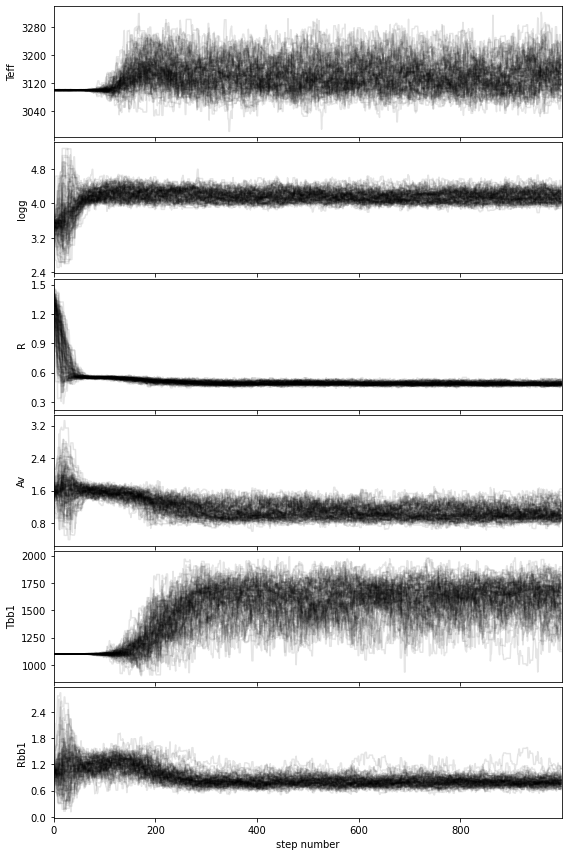

In [76]:
from special.mcmc_sampling import show_walk_plot

show_walk_plot(final_chain, labels)#, save=False,# output_dir='../datasets/',

If you wish to save the walk plot in a pdf, set `save=True` and provide a value for the output directory (`output_dir`).

Based on the walk plot, let's define a conservative burnin factor of 0.5 and apply it to the chain:

In [77]:
burnin=0.5

In [78]:
cutoff = int(final_chain.shape[1]//(1/burnin))
ngood_steps = final_chain.shape[1]-cutoff
samples_flat_BTS_BB = final_chain[:, cutoff:, :].reshape((-1,npar))

Let's compute the 68.27% confidence intervals on the posterior distribution, after burnin:

percentage for Teff: 69.61%
percentage for logg: 68.47299999999998%
percentage for R: 69.14199999999998%
percentage for Av: 69.606%
percentage for Tbb1: 69.51700000000001%
percentage for Rbb1: 68.31800000000003%
******* Results for Teff ***** 


Confidence intervals:
Teff: 3130.6105222183864 [-38.21114851147195,41.53385707768712]
******* Results for logg ***** 


Confidence intervals:
logg: 4.133703587809821 [-0.12273417511971374,0.13255290912928963]
******* Results for R ***** 


Confidence intervals:
R: 0.48638552523518036 [-0.01677604615473227,0.016776046154732327]
******* Results for Av ***** 


Confidence intervals:
Av: 0.963382392591819 [-0.11474009715433886,0.2113633368632557]
******* Results for Tbb1 ***** 


Confidence intervals:
Tbb1: 1644.822478359647 [-125.17933348754332,136.06449292124307]
******* Results for Rbb1 ***** 


Confidence intervals:
Rbb1: 0.7851754521420204 [-0.09900281702828406,0.08735542678966246]


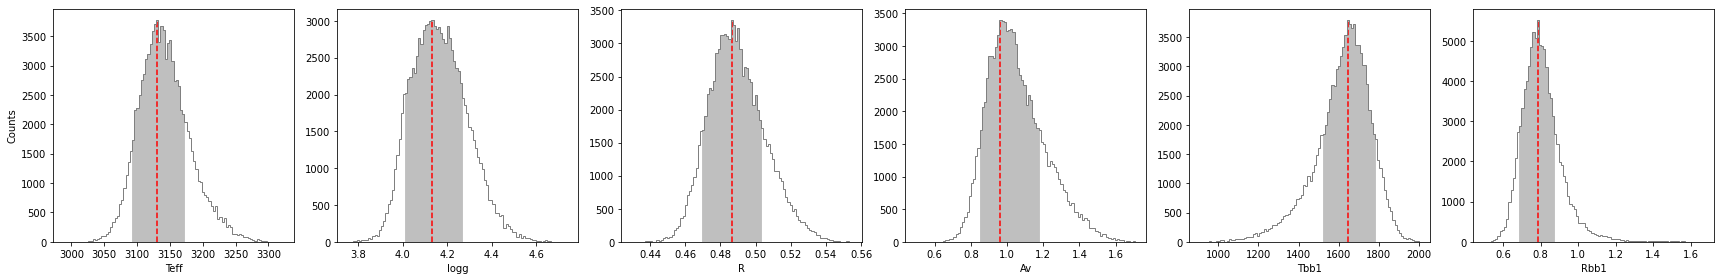

In [79]:
from special.mcmc_sampling import confidence

bins = 100
vals, err = confidence(samples_flat_BTS_BB, labels, cfd=68.27, bins=bins, 
                            gaussian_fit=False, weights=None, 
                            verbose=True, save=False, bounds=bounds, 
                            priors=None)

If you wish to save the results in a text file, set `save=True` and provide a value for the output directory (`output_dir`).

Let's define the most likely parameters along with their uncertainties in a numpy array:

In [80]:
post_params = np.zeros([npar,3])
for i in range(npar):
    post_params[i,0] = vals[labels[i]]
    post_params[i,1] = err[labels[i]][0]
    post_params[i,2] = err[labels[i]][1]

Now, let's have a look at the corner plot. A couple of parameters can be fine tuned for aesthetics, e.g.:

- number of significant digits for each parameter (`ndig`), 
- labels to be used in the plot for each parameter (`labels_plot` can be different to the string used in `labels` but `labels` is used if not provided), 
- font attributes for plot title and label, 
- number of bins to consider for the corner plot histograms.

In [81]:
ndig = (0,1,2,1,0,1) # should have same length as labels
labels_plot = (r'$T$', r'log($g$)', r'$R$',  r'$A_V$', r'$T_{bb1}$',r'$R_{bb1}$')
title_kwargs={"fontsize": 16}
label_kwargs={"fontsize": 16}
corner_bins = 20

If you wish to save the corner plot in pdf format, set `save=True` and provide a value to `plot_name`.

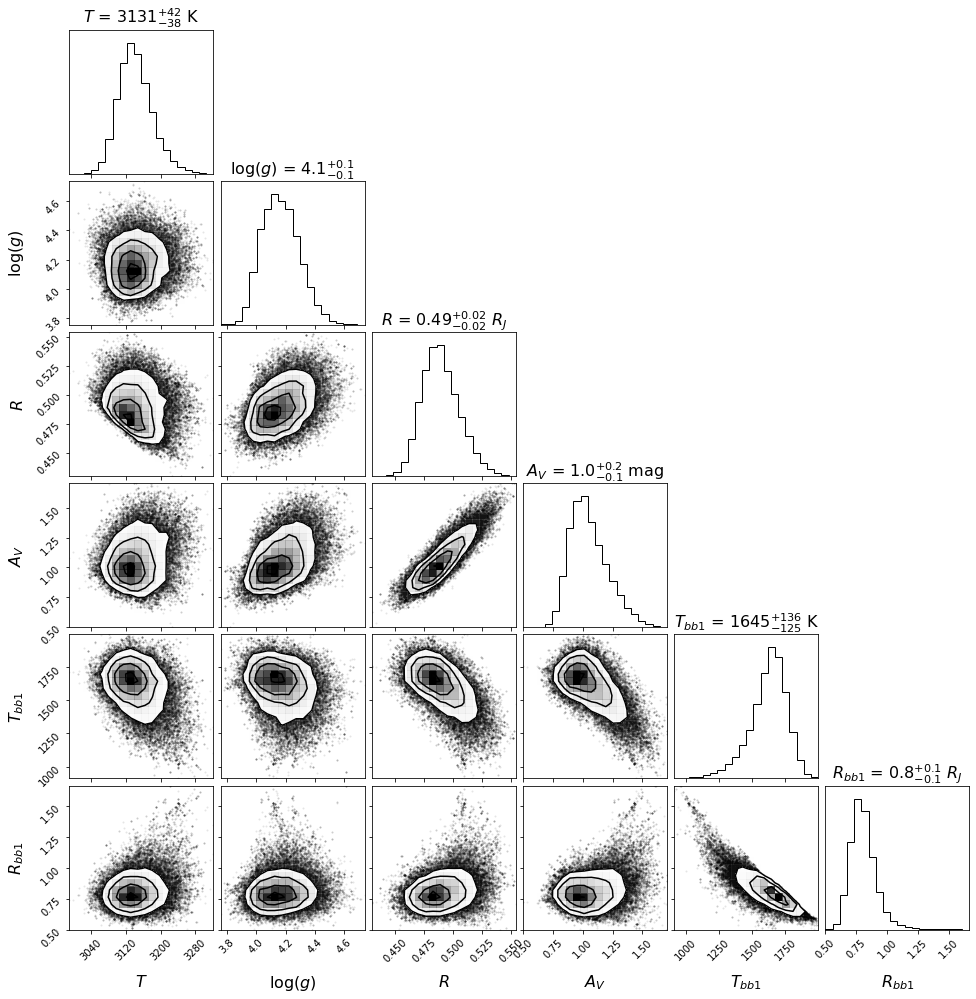

In [82]:
from special.mcmc_sampling import show_corner_plot

#note: provide the chain before burnin, since burnin is done internally here:
show_corner_plot(final_chain, burnin=burnin, save=False,  
                      mcmc_res=post_params, units=units, ndig=ndig, labels_plot=labels_plot,
                      labels=labels, #plot_name='corner_plot.pdf',
                      title_kwargs=title_kwargs, label_kwargs=label_kwargs, bins=corner_bins)

Let's save the likelihood and parameter values of the most likely model for later ([Sec. 5.2](#5.2.-Best-fit-models)):

In [83]:
# favoured model has highest likelihood
max_prob_BTS_BB = np.nanmax(ln_proba)
idx_max = np.unravel_index(np.nanargmax(ln_proba),shape=ln_proba.shape)
bf_params_BTS_BB = final_chain[idx_max]
bf_params_BTS_BB

array([3.11003067e+03, 4.09851594e+00, 4.77898990e-01, 9.03728496e-01,
       1.70870400e+03, 7.88314243e-01])

## 4.5. BT-SETTL model + BrG line model

In order to further showcase the possibilities available in `specfit`, let's now consider a BT-SETTL + Brackett Gamma line model for the spectrum. Let's also consider $R_V$ as a free parameter, and finally consider Gaussian priors for log($g$) and $R_V$: $\mu_{\mathrm{log}(g)}=3.5$, $\sigma_{\mathrm{log}(g)} = 0.2$ and $\mu_{R_V}=3.1$, $\sigma_{R_V} = 0.2$.  

This time, we have a total of 6 free parameters, including 2 captured by the BT-SETTL grid:

In [84]:
labels = ('Teff', 'logg', 'R', 'Av', 'Rv', 'BrG')
units = ('K', '', r'$R_J$', 'mag', '', '')
npar = len(labels)

teff_list = np.linspace(2000,4000,num=21).tolist()
logg_list = np.linspace(2.5,5.5,num=7).tolist()
grid_list = [teff_list, logg_list]

Provide estimate for BrG flux:

In [85]:
import astropy.constants as con
F_BrG_estimate = 20000 # W m-2 at the surface (based on the estimate for the primary)
RB_est = 5             # rough estimate for the radius of the companion in R_J
input_unit = 'LogL'    # select input units {'F','L','LogL'} for Flux (W/m2), Luminosity (W) or Log Solar Luminosity.

Conversion of F_BrG into LSun - do not change:

In [86]:
if input_unit == 'F':
    BrG_min = F_BrG_estimate*1e-5
    BrG_max = F_BrG_estimate*1e5  
elif input_unit == 'LogL':
    # BrG flux is converted below into L_Sun
    L_BrG_estimate = np.log10(4*np.pi*np.power(con.R_jup.value*RB_est,2)*F_BrG_estimate/con.L_sun.value)
    # set min and max of BrG list of initial grid of tested values
    BrG_min = L_BrG_estimate-5
    BrG_max = L_BrG_estimate+5
else:
    BrG_min = F_BrG_estimate*1e-5*4*np.pi*np.power(con.R_jup.value*RB_est,2)
    BrG_max = F_BrG_estimate*1e5*4*np.pi*np.power(con.R_jup.value*RB_est,2)     

Set the initial guesses and bounds accordingly. Note the requirement for a Jovian input radius.

In [87]:
# define list of BrG line luminosities
n_BrG_list = 23 # desired number of points in grid
BrG_list = np.linspace(L_BrG_estimate-5, L_BrG_estimate+5, n_BrG_list)
# during MCMC, sampled values will be interpolated from the grid defined above for faster calculation.

ini_guess = (3100., 3.5, 1.3, 1.6, 3.1, np.median(BrG_list))
bounds = {'Teff':(2000,4000), 
          'logg':(2.5,5.5), 
          'R':(0.1,5), 
          'Av':(0.,5),
          'Rv':(1.,6),
          'BrG': (L_BrG_estimate-5,L_BrG_estimate+5)}

Provide details for each of the line(s). Add an entry in the `em_lines` and `em_grid` dictionaries for each line you'd like to include in the model. Lines can be included in the model without necessarily fitting for their flux with MCMC (e.g. for a known emission line luminosity to be included in the model):

In [88]:
em_lines = {}
em_lines['BrG'] = (2.1667, input_unit, None) # WL, unit and flux (if known). Flux can be None if to be sampled by MCMC.

em_grid = {}
em_grid['BrG'] = BrG_list.copy()

Let's set Gaussian priors for $R_V$ in a dictionary. By default, uniform priors are considered for parameters not mentioned in this dictionary. Be sure to use the same dictionary labels as for parameter `labels`.

In [89]:
priors = {'logg':(3.5,0.2),
          'Rv':(3.1,0.2)}

Let's compile all model-related parameters defined above into a dictionary:

In [90]:
model_params={'grid_param_list':grid_list,
              'model_reader':bts_reader,
              'labels':labels,
              'initial_state':ini_guess,
              'bounds':bounds,
              'em_lines':em_lines,
              'em_grid':em_grid,
              'priors':priors,
              'units_mod':units_mod}

In order for the MCMC sampler to run faster, all models of the grid are first resampled (at the same sampling as the measured spectrum), such that only light spectra files are opened and interpolated during the sampling. To do so, set `resamp_before=True` and provide a path and name where the resampled grid will be saved:

In [91]:
grid_name='bts_BrG_resamp_grid.fits' 
output_dir='../static/bts_output/'
resamp_before=True

**Important**: if a file named `output_dir`+`grid_name` already exists it will be used, instead of creating a new resmpled grid (this is to save time when a given MCMC sampling is performed multiple times with different options). Make sure to change either `output_dir` or `grid_name` when considering different models or a different range of parameter values in the grid (i.e. different `grid_list`).

We also set a filename where the MCMC results will be written as a pickle, such that they can be accessed without having to run again the MCMC.

In [92]:
output_file = 'MCMC_results_BrG' # also written in output_dir

output_params = {'resamp_before':resamp_before,
                 'grid_name':grid_name,
                 'output_dir': output_dir,
                 'output_file': output_file}

Finally, given the larger number of parameters, let's increase the number of iterations and walkers:

In [93]:
a=2.0
nwalkers=200
niteration_min=100
niteration_limit=1000 # recommended>> 1000
nproc = 2             # number of CPUs

mcmc_params = {'a':a,
               'nwalkers':nwalkers,
               'niteration_min':niteration_min,
               'niteration_limit':niteration_limit,
               'nproc':nproc}

Now let's run the MCMC sampler (**Warning: the next cell may take a few minutes to complete**):

In [94]:
from special.mcmc_sampling import mcmc_spec_sampling

res = mcmc_spec_sampling(lbda, spec, spec_err, d_st, dlbda_obs=dlbda, **instru_params, 
                                      **mcmc_params, **conv_params, **model_params, **output_params)

Fits HDU-0 data successfully loaded. Data shape: (21, 7, 23, 42, 2)


In [95]:
final_chain, ln_proba = res
if star:
    idx_R = labels.index('R')
    final_chain[:,:,idx_R] = final_chain[:,:,idx_R].copy()*conv_RS
    # change units of radius
    units = list(units)
    units[-1] = r'$R_{\odot}$'
    units = tuple(units)

Let's inspect the walk plot:

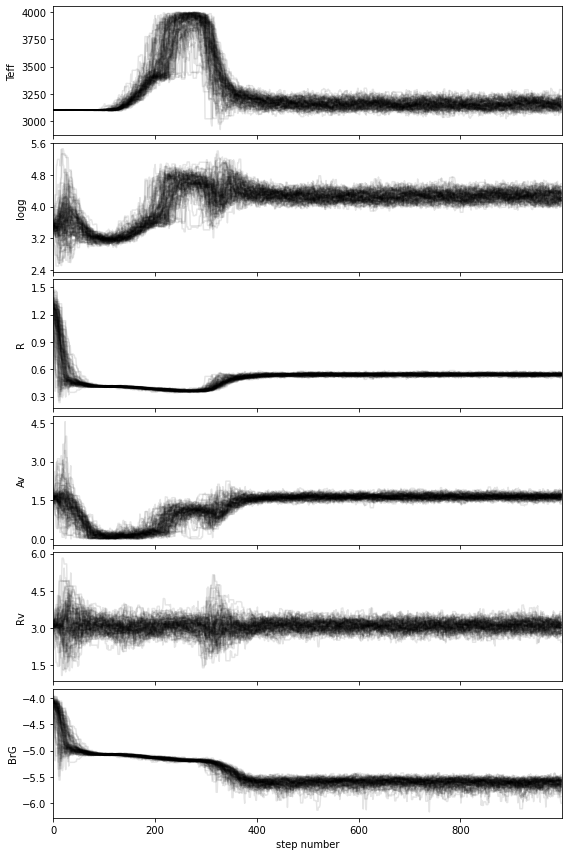

In [96]:
from special.mcmc_sampling import show_walk_plot

show_walk_plot(final_chain, labels)#, save=False,# output_dir='../datasets/',

If you wish to save the walk plot in a pdf, set `save=True` and provide a value for the output directory (`output_dir`).

Based on the walk plot, let's define a conservative burnin factor of 0.5 and apply it to the chain:

In [97]:
burnin=0.5

In [98]:
cutoff = int(final_chain.shape[1]//(1/burnin))
ngood_steps = final_chain.shape[1]-cutoff
samples_flat_BrG = final_chain[:, cutoff:, :].reshape((-1,npar)) 

Let's compute the 68.27% confidence intervals on the posterior distribution, after burnin:

percentage for Teff: 69.04%
percentage for logg: 69.697%
percentage for R: 68.30100000000002%
percentage for Av: 68.92399999999998%
percentage for Rv: 69.12299999999999%
percentage for BrG: 70.992%
******* Results for Teff ***** 


Confidence intervals:
Teff: 3141.9655128635877 [-35.14668313511038,40.77015243672804]
******* Results for logg ***** 


Confidence intervals:
logg: 4.243576014919358 [-0.11864421923623603,0.13762729431403375]
******* Results for R ***** 


Confidence intervals:
R: 0.5442448553227712 [-0.013274692447501568,0.011308071344168003]
******* Results for Av ***** 


Confidence intervals:
Av: 1.6488730533715068 [-0.10833213348343262,0.07623372356241553]
******* Results for Rv ***** 


Confidence intervals:
Rv: 3.093438524216414 [-0.2113715800566638,0.21137158005666423]
******* Results for BrG ***** 


Confidence intervals:
BrG: -5.5988926732419 [-0.06772295968008102,0.07675268763742604]


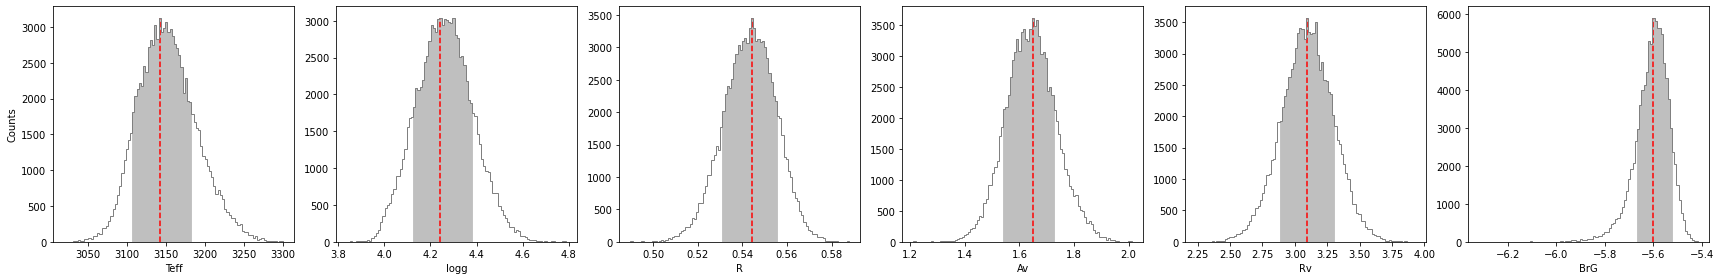

In [99]:
from special.mcmc_sampling import confidence

bins = 100
vals, err = confidence(samples_flat_BrG, labels, cfd=68.27, bins=bins, gaussian_fit=False, weights=None, 
                            verbose=True, save=False, bounds=bounds, priors=None)

If you wish to save the results in a text file, set `save=True` and provide a value for the output directory (`output_dir`).

Let's define the most likely parameters along with their uncertainties in a numpy array:

In [100]:
post_params = np.zeros([npar,3])
for i in range(npar):
    post_params[i,0] = vals[labels[i]]
    post_params[i,1] = err[labels[i]][0]    
    post_params[i,2] = err[labels[i]][1]

Now, let's have a look at the corner plot. A couple of parameters can be fine tuned for aesthetics, e.g.:

- number of significant digits for each parameter (`ndig`), 
- labels to be used in the plot for each parameter (`labels_plot` can be different to the string used in `labels` but `labels` is used if not provided), 
- font attributes for plot title and label, 
- number of bins to consider for the corner plot histograms.

In [101]:
ndig = (0,1,2,1,1,1) # should have same length as labels
labels_plot = (r'$T$', r'log($g$)', r'$R$',  r'$A_V$',  r'$R_V$', r"$\log(\frac{L_{\rm BrG}}{L_{\odot}})$")
title_kwargs={"fontsize": 16}
label_kwargs={"fontsize": 16}
corner_bins = 20

If you wish to save the corner plot in pdf format, set `save=True` and provide a value to `plot_name`.

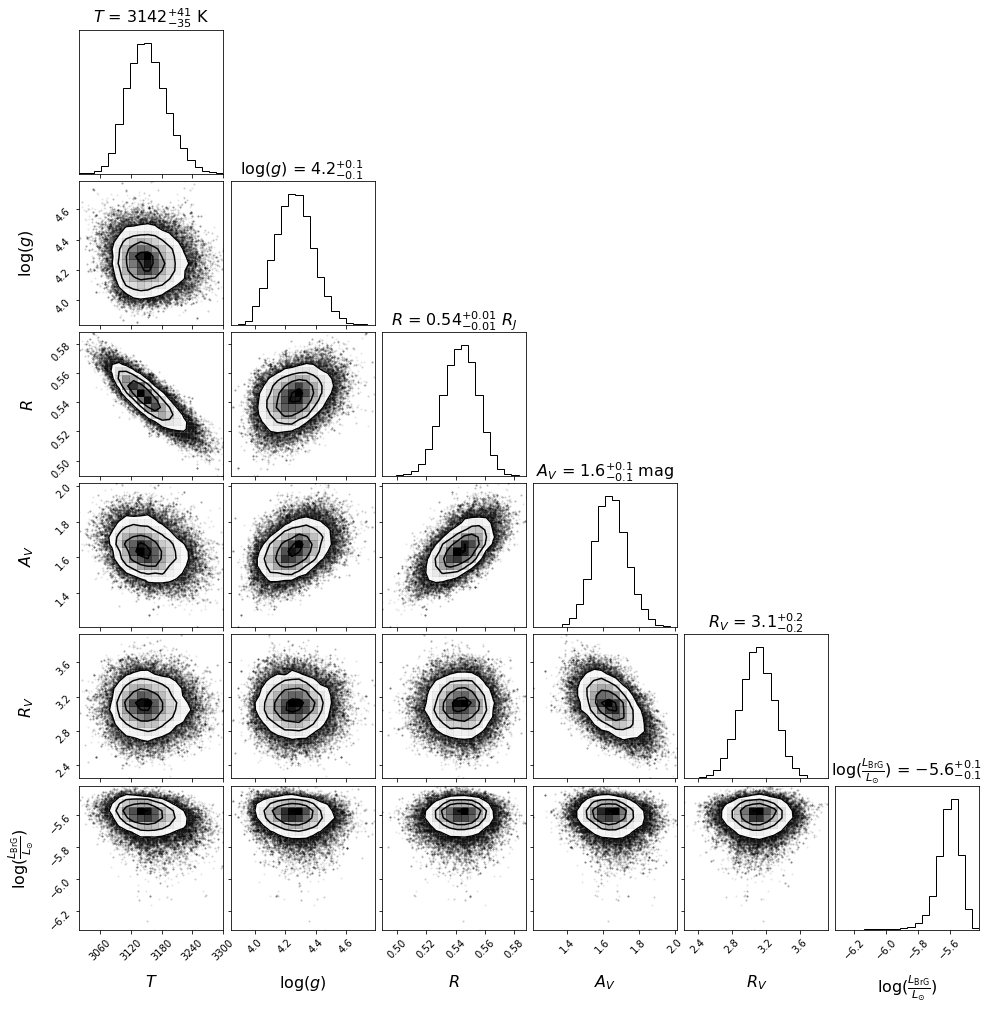

In [102]:
from special.mcmc_sampling import show_corner_plot

#note: provide the chain before burnin, since burnin is done internally here:
show_corner_plot(final_chain, burnin=burnin, save=False,  
                      mcmc_res=post_params, units=units, ndig=ndig, labels_plot=labels_plot,
                      labels=labels, #plot_name='corner_plot.pdf',
                      title_kwargs=title_kwargs, label_kwargs=label_kwargs, bins=corner_bins)

Compared to the results obtained without the inclusion of a potential BrG line (affecting the K1 photometry of the point source), we now get a lower value of log(g), more consistent with a young object. Nonetheless, the required BrG line luminosity is significant. This would likely imply the presence of more H recombination lines - which may or may not be present near ~1.09 and ~1.22 $\mu$m (see below).

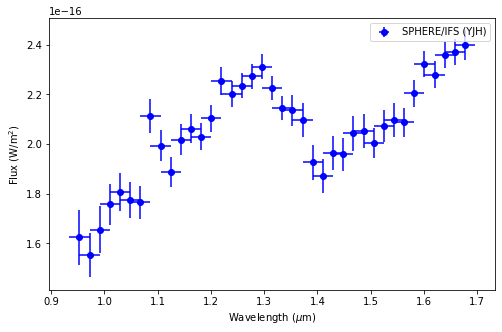

In [103]:
fig = plt.figure(figsize=figsize)
plt.errorbar(lbda[:-3], lbda[:-3]*spec[:-3], lbda[:-3]*spec_err[:-3], dlbda[:-3], 'bo', 
             label = 'SPHERE/IFS (YJH)')
plt.xlabel(r"Wavelength ($\mu$m)")
plt.ylabel(r"Flux (W/m$^2$)")
plt.legend()

Let's save the likelihood and parameter values of the most likely model for later ([Sec. 5.2](#5.2.-Best-fit-models)):

In [104]:
# favoured model has highest likelihood
max_prob_BTS_BrG = np.nanmax(ln_proba)
idx_max = np.unravel_index(np.nanargmax(ln_proba),shape=ln_proba.shape)
bf_params_BTS_BrG = final_chain[idx_max]
bf_params_BTS_BrG

array([ 3.14920546e+03,  4.23347893e+00,  5.43523102e-01,  1.63279269e+00,
        3.09368726e+00, -5.59453384e+00])

[Go to the top](#Table-of-contents)

# 5. Comparison of results

## 5.1. Akaike Information Criterion

For each of the tested type of model above (Secs. 4.2 to 4.5), let's compute the Akaike Information Criterion (AIC) in order to assess which one is likely the best model for our observations. The 4 tested models are:

- Blackbody (2 parameters);
- BT-SETTL + extinction (4 parameters);
- BT-SETTL + 2BB + extinction (8 parameters); 
- BT-SETTL + BrG + extinction (6 parameters)

For each type of model, we need the maximum likelihood model among all MCMC samples, and the number of free parameters.

In [105]:
nparam_list = [2, 4, 6, 6]
max_prob_list = [max_prob_BB, max_prob_BTS, max_prob_BTS_BB, max_prob_BTS_BrG]

n_models = len(nparam_list)

In [106]:
from special.utils_spec import akaike

aic_list = [akaike(max_prob_list[i],nparam_list[i]) for i in range(n_models)]
aic_list

[269.38762220442425,
 139.53666919929782,
 132.71695323794222,
 145.31412846810852]

Now let's compute the $\Delta$ AIC, i.e. the difference with the smallest AIC value obtained for the different models:


In [107]:
min_aic = np.amin(aic_list)

daic_list = [aic_list[i]-min_aic for i in range(n_models)]
daic_list

[136.67066896648203, 6.819715961355598, 0.0, 12.5971752301663]

The values above suggest that the most likely types of model that we considered are the BT-SETTL alone, the BT-SETTL+BB and BT-SETTL+BrG line models.

Since the difference is >>10 for the BB model, we can conclude that there is no support for that kind of model (Burnham & Anderson 2002).

[Go to the top](#Table-of-contents)

## 5.2. Best-fit models

Let's first assemble all the relevant parameters from the different models considered above in different lists:

In [108]:
lab_models = ['BB', 'BT-SETTL', 'BT-SETTL + BB', 'BT-SETTL + BrG line']
bf_params = [bf_params_BB, bf_params_BTS, bf_params_BTS_BB, bf_params_BTS_BrG]
all_samples_flat = [samples_flat_BB, samples_flat_BTS, samples_flat_BTS_BB, samples_flat_BrG]
all_labels = [('Tbb1', 'Rbb1'),
              ('Teff', 'logg', 'R', 'Av'),
              ('Teff', 'logg', 'R', 'Av', 'Tbb1', 'Rbb1'),
              ('Teff', 'logg', 'R', 'Av', 'Rv', 'BrG')]
all_grid_lists = [None, grid_list, grid_list, grid_list]
all_em_lines = [{}, {}, {}, em_lines]
all_em_grids = [{}, {}, {}, em_grid]
all_ndig = [(0,2),
            (0,1,2,1),
            (0,1,2,1,0,1),
            (0,1,2,1,1,1)]
all_units = [('K', r'$R_J$'),
             ('K', '', r'$R_J$', 'mag'),
             ('K', '', r'$R_J$', 'mag', 'K', r'$R_J$'),
             ('K', '', r'$R_J$', 'mag', '', '')]

n_models = len(lab_models)

In [109]:
bf_params

[array([2.58128969e+03, 7.39761626e-01]),
 array([3.16633525e+03, 5.00426271e+00, 5.62017189e-01, 1.81206806e+00]),
 array([3.11003067e+03, 4.09851594e+00, 4.77898990e-01, 9.03728496e-01,
        1.70870400e+03, 7.88314243e-01]),
 array([ 3.14920546e+03,  4.23347893e+00,  5.43523102e-01,  1.63279269e+00,
         3.09368726e+00, -5.59453384e+00])]

Now for each type of model considered above, let's now generate the spectrum corresponding to the most likely parameters inferred with the MCMC. 
By providing `lbda_obs` to `make_model_from_params`, the returned model will be resampled to match the spectral resolution of the measured spectrum. If provided, the instrumental spectral FWHM and/or photometric filter(s) will also be used. If `lbda_obs` is left to None, the model is returned at the native resolution of the grid used as input. Let's leverage this to have both high-res and resampled spectra.

In [110]:
from special.model_resampling import make_model_from_params

bf_models = []
bf_models_hr = []

for nn in range(n_models):
    bf_params_nn = tuple(bf_params[nn])
    lbda_model, flux_model = make_model_from_params(bf_params_nn, 
                                                    all_labels[nn], 
                                                    all_grid_lists[nn], 
                                                    d_st, 
                                                    model_reader=bts_reader, 
                                                    em_lines=all_em_lines[nn], 
                                                    em_grid=all_em_grids[nn], 
                                                    units_obs=units_obs, 
                                                    units_mod=units_mod, 
                                                    interp_order=1,
                                                    lbda_obs=lbda,
                                                    dlbda_obs=dlbda,
                                                    instru_fwhm=instru_fwhm, 
                                                    instru_idx=instru_idx, 
                                                    filter_reader=filter_reader)
    bf_models.append([lbda_model, flux_model])
    if nn > 0:
        lbda_model_hr, flux_model_hr = make_model_from_params(bf_params_nn, 
                                                              all_labels[nn], 
                                                              all_grid_lists[nn], 
                                                              d_st, 
                                                              model_reader=bts_reader, 
                                                              em_lines=all_em_lines[nn], 
                                                              em_grid=all_em_grids[nn], 
                                                              units_obs=units_obs, 
                                                              units_mod=units_mod, 
                                                              interp_order=1)
        bf_models_hr.append([lbda_model_hr, flux_model_hr])

For models not based on a grid, `lbda_obs` is a mandatory parameter, hence the avoidance of the BB model for high-res models. Let's use the output `lbda_model_hr` from BT-SETTL models, to add a high-res spectrum for the BB model as well.

In [111]:
lbda_model_hr, flux_model_hr = make_model_from_params(tuple(bf_params[0]), 
                                                      all_labels[0], 
                                                      all_grid_lists[0], 
                                                      d_st, 
                                                      model_reader=bts_reader, 
                                                      em_lines=all_em_lines[0], 
                                                      em_grid=all_em_grids[0], 
                                                      units_obs=units_obs, 
                                                      units_mod=units_mod, 
                                                      interp_order=1,
                                                      lbda_obs=bf_models_hr[-1][0])
bf_models_hr = [[lbda_model_hr, flux_model_hr]]+bf_models_hr

Now crop the model spectra to the same wavelength range as the measured spectrum:

In [112]:
from special.utils_spec import find_nearest

for nn in range(n_models):
    lbda_model_hr, flux_model_hr = bf_models_hr[nn]
    # LOAD BEST FIT MODEL
    idx_ini = find_nearest(lbda_model_hr,0.99*lbda[0], constraint='floor')
    idx_fin = find_nearest(lbda_model_hr,1.01*lbda[-1], constraint='ceil')
    lbda_model_hr = lbda_model_hr[idx_ini:idx_fin+1]
    flux_model_hr = flux_model_hr[idx_ini:idx_fin+1]
    dlbda_hr = np.mean(lbda_model_hr[1:]-lbda_model_hr[:-1])
    bf_models_hr[nn] = [lbda_model_hr, flux_model_hr]

Now let's plot the best-fit models at their native resolution (first panel) and after resampling (second panel):

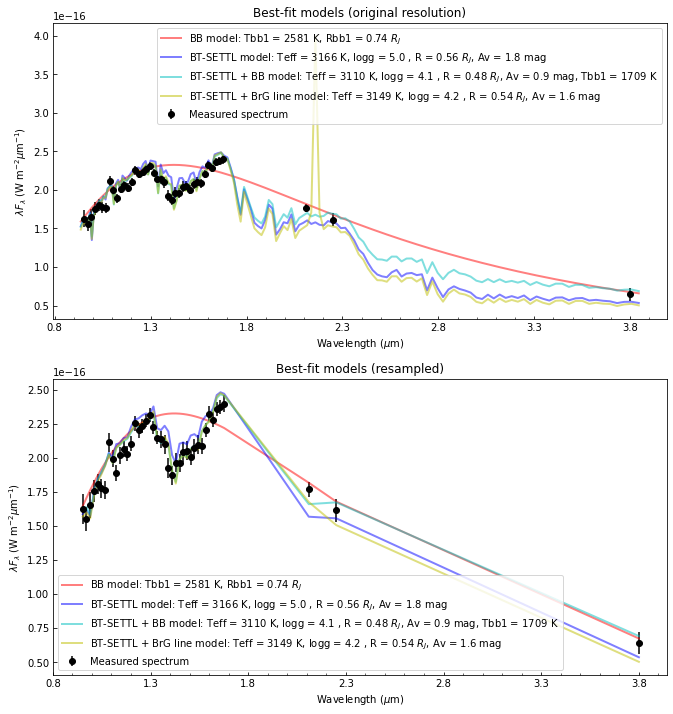

In [113]:
fig, axes = plt.subplots(2,1,figsize=(11,12))

# plot options
cols = ['k', 'r', 'b', 'c', 'y', 'm'] # colors of different models
maj_tick_sp = 0.5 # WL spacing for major ticks
min_tick_sp = maj_tick_sp / 5. # WL spacing for minor ticks

# Titles
axes[0].set_title("Best-fit models (original resolution)")
axes[1].set_title("Best-fit models (resampled)")

# Plot measured spectrum
axes[0].errorbar(lbda, lbda*spec, 
             lbda*spec_err, fmt=cols[0]+'o', 
             label='Measured spectrum')
axes[1].errorbar(lbda, lbda*spec, 
             lbda*spec_err, fmt=cols[0]+'o', 
             label='Measured spectrum')

# Set axes labels
axes[0].set_xlabel(r"Wavelength ($\mu$m)")
axes[0].set_ylabel(r"$\lambda F_{\lambda}$ (W m$^{-2} \mu$m$^{-1}$)")
axes[1].set_xlabel(r"Wavelength ($\mu$m)")
axes[1].set_ylabel(r"$\lambda F_{\lambda}$ (W m$^{-2} \mu$m$^{-1}$)")

# Plot best-fit models
for i in range(2):
    if i == 0:
        bf_models_i = bf_models_hr
    else:
        bf_models_i = bf_models
    for nn in range(n_models):
        lbda_model, flux_model = bf_models_i[nn]

        lab_str = '{0} = {1:.{2}f} {3}'
        if nn==0 or nn ==1:
            show_labs = range(len(bf_params[nn]))
        elif nn==2:
            show_labs = range(len(bf_params[nn])-1)
        else:
            show_labs = list(range(len(bf_params[nn])-2))
        lab_str_list = [lab_str.format(all_labels[nn][j], bf_params[nn][j], all_ndig[nn][j], all_units[nn][j]) for j in show_labs]
        sep = ', '
        label = "{} model: {}".format(lab_models[nn], sep.join(lab_str_list))
        axes[i].plot(lbda_model, lbda_model*flux_model, cols[1+nn], linewidth=2,
                 alpha=0.5, label=label)

        min_tick = lbda[0]-dlbda[0]/2-((lbda[0]-dlbda[0]/2)%0.2)
        max_tick = lbda[-1]+dlbda[-1]/2+(0.2-((lbda[-1]+dlbda[-1]/2)%0.2))
        major_ticks1 = np.arange(min_tick,max_tick,maj_tick_sp)
        minor_ticks1 = np.arange(min_tick,max_tick,min_tick_sp)

        axes[i].set_xticks(major_ticks1)
        axes[i].set_xticks(minor_ticks1, minor = True)
        axes[i].tick_params(which = 'both', direction = 'in')
        axes[i].legend(loc='best')    

plt.show()

[Go to the top](#Table-of-contents)

## 5.3. Models from the posterior distribution

It can be useful to plot a large number of models randomly picked from the posterior distribution in order to have an idea of the uncertainty in different parts of the spectrum. Let's consider 200 samples from the posterior distribution:

In [114]:
n_samp = 200

In [115]:
import random

all_plot_samples = []
for nn in range(n_models):
    print("################## Model {} ##################".format(lab_models[nn]))
    samp_flux = []
    lbda_samp = None # use native model resolution (set to `lbda` for measured spectrum sampling)
    if nn == 0:
        # set the wavelength sampling for 
        lbda_samp=bf_models_hr[-1][0]
    for ii in range(n_samp):
        # draw a random integer
        idx = random.randint(0, len(all_samples_flat[nn]))
        param_samp = tuple(all_samples_flat[nn][idx])
        samp_lbda, tmp = make_model_from_params(param_samp, all_labels[nn], all_grid_lists[nn], d_st,
                                                model_reader=bts_reader, em_lines=all_em_lines[nn], 
                                                em_grid=all_em_grids[nn], units_obs=units_obs, 
                                                units_mod=units_mod, interp_order=1, lbda_obs=lbda_samp)
        
        samp_flux.append(tmp)
    # Crop to same range as measurements
    idx_ini = find_nearest(samp_lbda,0.99*lbda[0], constraint='floor')
    idx_fin = find_nearest(samp_lbda,1.01*lbda[-1], constraint='ceil')
    samp_lbda = samp_lbda[idx_ini:idx_fin+1]
    samp_fluxes = [samp_flux[ii][idx_ini:idx_fin+1] for ii in range(n_samp)]
    all_plot_samples.append([samp_lbda,samp_fluxes])

################## Model BB ##################
################## Model BT-SETTL ##################
################## Model BT-SETTL + BB ##################
################## Model BT-SETTL + BrG line ##################


/Users/valentin/GitHub/special/special/model_resampling.py:250: RuntimeWarning: overflow encountered in power
  flux_ratio_ext = np.power(10.,-extinc_curve/2.5)


Now let's plot the samples:

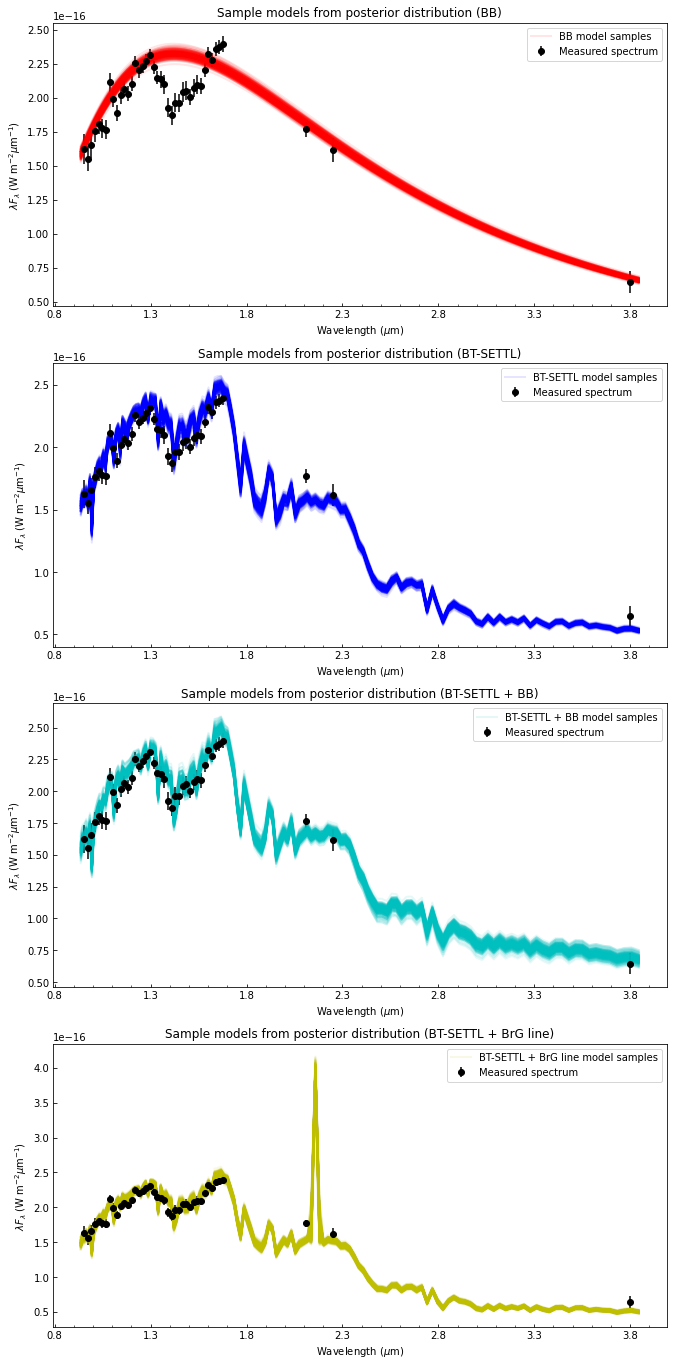

In [116]:
fig, axes = plt.subplots(4,1,figsize=(11,24))

# plot options
cols = ['k', 'r', 'b', 'c', 'y', 'm'] # colors of different models
maj_tick_sp = 0.5 # WL spacing for major ticks
min_tick_sp = maj_tick_sp / 5. # WL spacing for minor ticks

# Titles
for nn in range(n_models):
    axes[nn].set_title("Sample models from posterior distribution ({})".format(lab_models[nn]))

    # Set axes labels
    axes[nn].set_xlabel(r"Wavelength ($\mu$m)")
    axes[nn].set_ylabel(r"$\lambda F_{\lambda}$ (W m$^{-2} \mu$m$^{-1}$)")

    # Options depending on model
    if nn==0 or nn ==1:
        show_labs = range(len(bf_params[nn]))
    elif nn==2:
        show_labs = range(len(bf_params[nn])-1)
    else:
        show_labs = list(range(len(bf_params[nn])-2))
    
    # Plot sample models
    lbda_samp, fluxes_model = all_plot_samples[nn]
    for i in range(n_samp):
        flux_model = fluxes_model[i]
        if i == 0:
            lab_str = '{0} = {1:.{2}f} {3}'
            lab_str_list = [lab_str.format(all_labels[nn][j], bf_params[nn][j], all_ndig[nn][j], all_units[nn][j]) for j in show_labs]
            sep = ', '
            label = "{} model samples".format(lab_models[nn])#: {}".format(lab_models[nn], sep.join(lab_str_list))
        else:
            label = None
        axes[nn].plot(lbda_samp, lbda_samp*flux_model, cols[1+nn], linewidth=2, alpha=0.1, label=label)

    min_tick = lbda[0]-dlbda[0]/2-((lbda[0]-dlbda[0]/2)%0.2)
    max_tick = lbda[-1]+dlbda[-1]/2+(0.2-((lbda[-1]+dlbda[-1]/2)%0.2))
    major_ticks1 = np.arange(min_tick,max_tick,maj_tick_sp)
    minor_ticks1 = np.arange(min_tick,max_tick,min_tick_sp)

    axes[nn].set_xticks(major_ticks1)
    axes[nn].set_xticks(minor_ticks1, minor = True)
    axes[nn].tick_params(which = 'both', direction = 'in')
            

    # Plot measured spectrum
    axes[nn].errorbar(lbda, lbda*spec, 
                     lbda*spec_err, fmt=cols[0]+'o', 
                     label='Measured spectrum')
    axes[nn].legend(loc='best')
        
plt.show()

[Go to the top](#Table-of-contents)

# 6. Nested sampler examples

The procedure is very similar to set the MCMC and the nested sampler routines as most parameters of `mcmc_spec_sampling` and `nested_spec_sampling` are identical.

The only differences are the `method`, `npoints`, `dlogz`, `decline_factor` and `rstate` parameters for the nested sampler. Most importantly the `method` can be set to `'classic'` (mcmc; Skilling 2004), `'single'` (single ellipsoid; Mutherjee et al. 2006) or `'multi'` (original multinest implementation as in Feroz et al. 2009, with conservative ellipsoid splitting).

The interested user is referred to the documentation of [nestle](http://kylebarbary.com/nestle/) for details on how to appropriately set these parameters.

Below we just show the example for running the nested sampler with the BT-SETTL grid, considering A_V as a free parameter. Let's first set the parameters as in [Sec. 4.3](#4.3.-BT-SETTL-model):

In [117]:
from utils import bts_reader

teff_list = np.linspace(2000,4000,num=21).tolist()
logg_list = np.linspace(2.5,5.5,num=7).tolist()
grid_list = [teff_list, logg_list]

ini_guess = (3100., 3.5, 1.3, 1.6)

labels = ('Teff', 'logg', 'R', 'Av')
labels_plot = (r'$T$', r'log($g$)', r'$R$',  r'$A_V$')
units = ('K', '', r'$R_J$', 'mag')
ndig = (0,1,2,1) # number of significant digits
units_mod = 'si'
bounds = {'Teff':(2000,4000), 
          'logg':(2.5,5.5), 
          'R':(0.1,5), 
          'Av':(0.,5)}
model_params={'grid_param_list':grid_list,
              'model_reader':bts_reader,
              'labels':labels,
              'bounds':bounds,
              'units_mod':units_mod}

grid_name='bts_resamp_grid.fits' 
output_dir='../static/bts_output/'
resamp_before=True
output_params = {'resamp_before':resamp_before,
                 'grid_name':grid_name,
                 'output_dir': output_dir}

## 6.1. Single ellipsoid method

Now let's set the parameters that are specific to the nested sampler:

In [118]:
method='single' 
npoints=150
dlogz=0.1
decline_factor=None
rstate=None

In [119]:
nestle_params = {'method':method,
                 'npoints':npoints,
                 'dlogz':dlogz,
                 'decline_factor':decline_factor,
                 'rstate':rstate}

Now let's run the nested sampler (**Warning: the next cell may take up to a few minutes to complete**):

In [120]:
from special.nested_sampling import nested_spec_sampling

res = nested_spec_sampling(ini_guess, lbda, spec, spec_err, d_st, dlbda_obs=dlbda, **instru_params,
                           **nestle_params, **model_params, **output_params)


Fits HDU-0 data successfully loaded. Data shape: (21, 7, 42, 2)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-02-21 14:08:37
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Prior bounds on parameters:
Teff [2000,4000]
logg [2.5,5.5]
R [0.1,5]
Av [0.0,5]

Using 150 active points

Total running time:
Running time:  0:00:26.177879
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Now let's plot the results:

niter: 2608
ncall: 7644
nsamples: 2758
logz: -80.836 +/-  0.295
h: 13.069

Natural log of prior volume and Weight corresponding to each sample


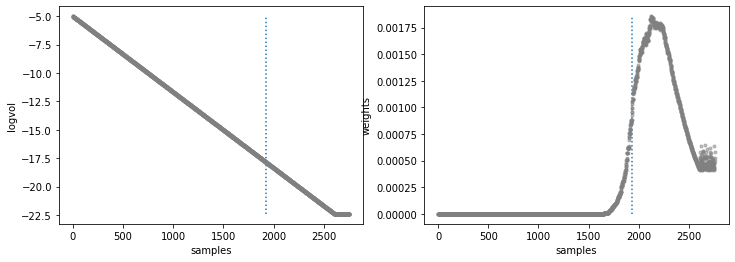


Walk plots before the burnin


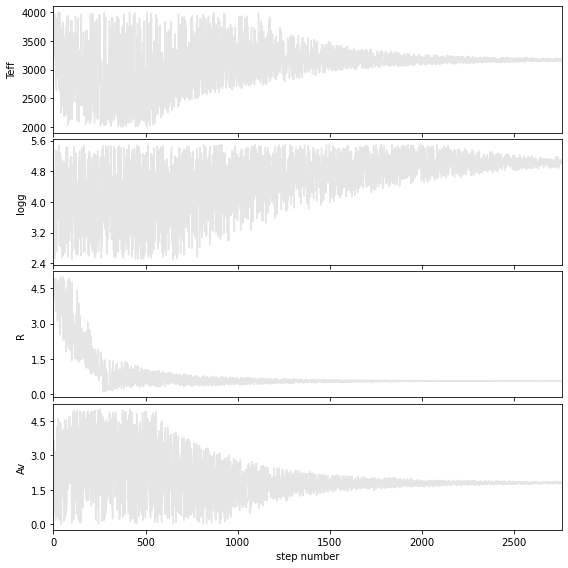


Walk plots after the burnin


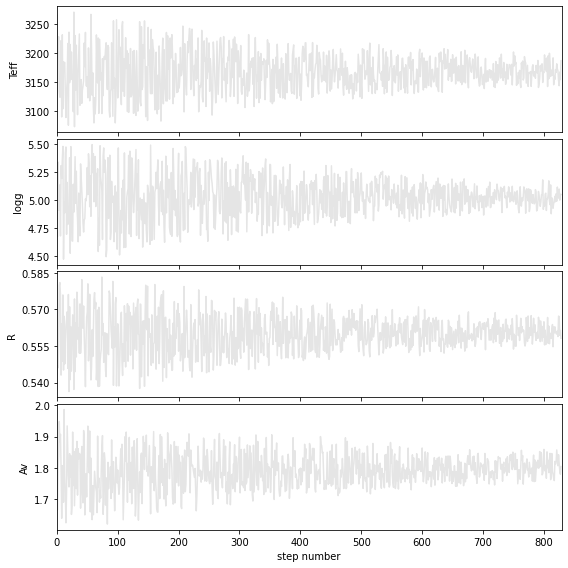


Weighted mean +- sqrt(covariance)
Teff = 3167 +/- 37
logg = 5.0 +/- 0.2
R = 0.56 +/- 0.01
Av = 1.8 +/- 0.1

Hist bins = 28


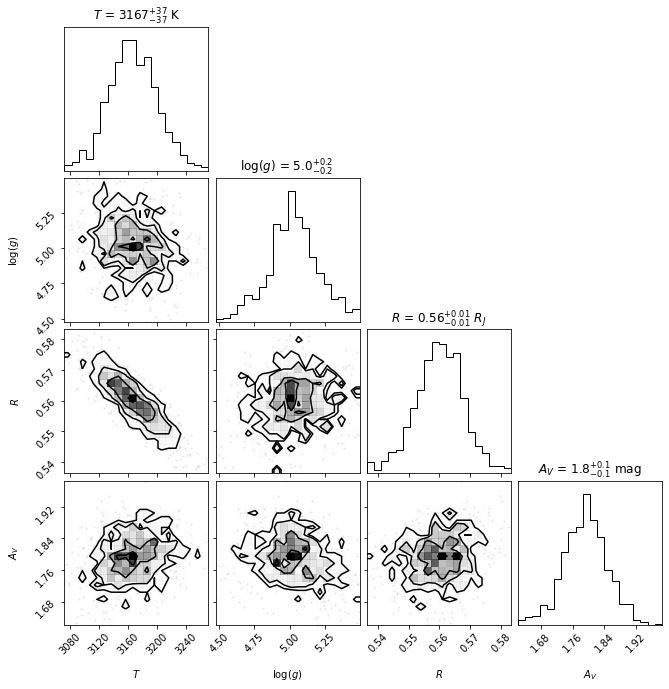


Confidence intervals
percentage for Teff: 69.91691215360272%
percentage for logg: 69.73991339243875%
percentage for R: 70.37490664221826%
percentage for Av: 71.95418259041931%
******* Results for Teff ***** 


Confidence intervals:
Teff: 3189.1161022225137 [-73.97595963269214,17.61332372206971]
Gaussian fit results:
Teff: 3166.848437716053 +-33.43459614242705
******* Results for logg ***** 


Confidence intervals:
logg: 5.040133703942271 [-0.20012625970246223,0.23651285237563702]
Gaussian fit results:
logg: 5.026419798475151 +-0.18170257226833855
******* Results for R ***** 


Confidence intervals:
R: 0.5606272430102227 [-0.012587339020463495,0.007552403412278252]
Gaussian fit results:
R: 0.5599027226203881 +-0.007911314208528912
******* Results for Av ***** 


Confidence intervals:
Av: 1.7974842018425952 [-0.0846897109966327,0.04560215207510998]
Gaussian fit results:
Av: 1.7918679015740873 +-0.055178556296219386


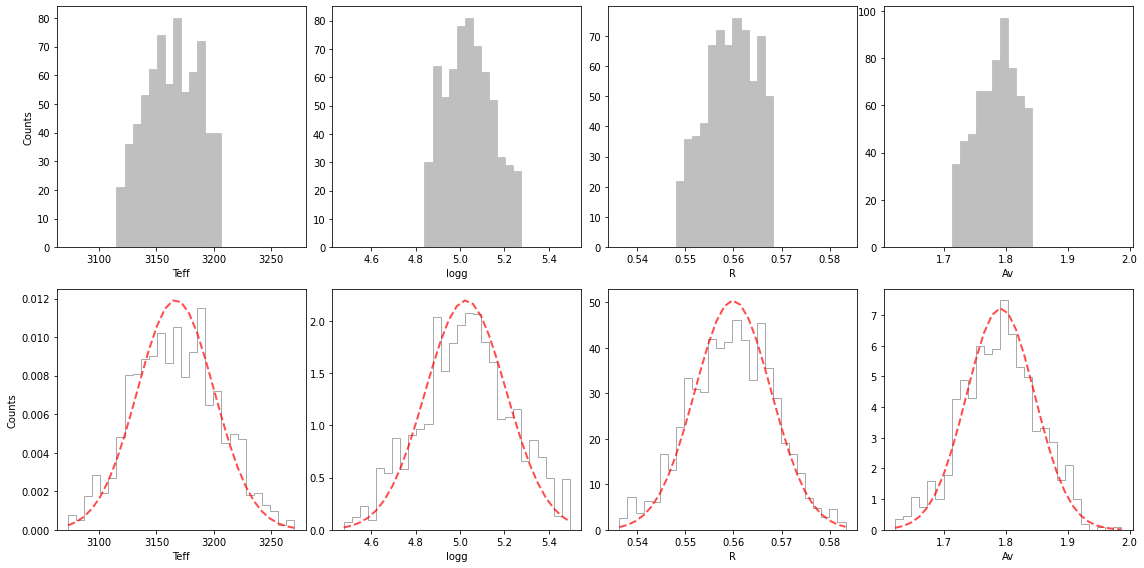

In [121]:
from special.nested_sampling import nested_sampling_results

final_res = nested_sampling_results(res, labels, burnin=0.7, bins=None, cfd=68.27, units=units, 
                                    ndig=ndig, labels_plot=labels_plot, save=False, 
                                    output_dir='./', plot=True)

The best-fit parameters, with uncertainty are:

In [122]:
for p in range(len(labels)):
    fmt = "{{:.{0}f}}".format(ndig[p]).format
    line = r"{0}: {1}+/-{2} {3}"
    print(line.format(labels[p],fmt(final_res[p][0]),fmt(final_res[p][1]), units[p]))

Teff: 3167+/-37 K
logg: 5.0+/-0.2 
R: 0.56+/-0.01 $R_J$
Av: 1.8+/-0.1 mag


## 6.2. Multi-ellipsoid method

Let's adapt the method and number of active points:

In [123]:
method='multi' 
npoints=300
dlogz=0.5
decline_factor=None
rstate=None

In [124]:
nestle_params = {'method':method,
                 'npoints':npoints,
                 'dlogz':dlogz,
                 'decline_factor':decline_factor,
                 'rstate':rstate}

Now let's run the nested sampler (**Warning: the next cell may take up to a few minutes to complete**):

In [125]:
from special.nested_sampling import nested_spec_sampling

res = nested_spec_sampling(ini_guess, lbda, spec, spec_err, d_st, dlbda_obs=dlbda, **instru_params,
                           **nestle_params, **model_params, **output_params)


Fits HDU-0 data successfully loaded. Data shape: (21, 7, 42, 2)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-02-21 14:09:05
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Prior bounds on parameters:
Teff [2000,4000]
logg [2.5,5.5]
R [0.1,5]
Av [0.0,5]

Using 300 active points

Total running time:
Running time:  0:00:47.429481
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Now let's plot the results:

niter: 4721
ncall: 13635
nsamples: 5021
logz: -80.907 +/-  0.209
h: 13.053

Natural log of prior volume and Weight corresponding to each sample


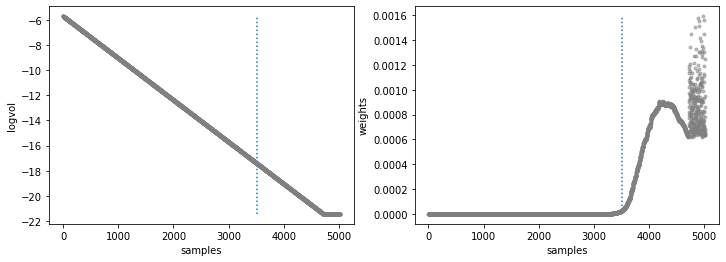


Walk plots before the burnin


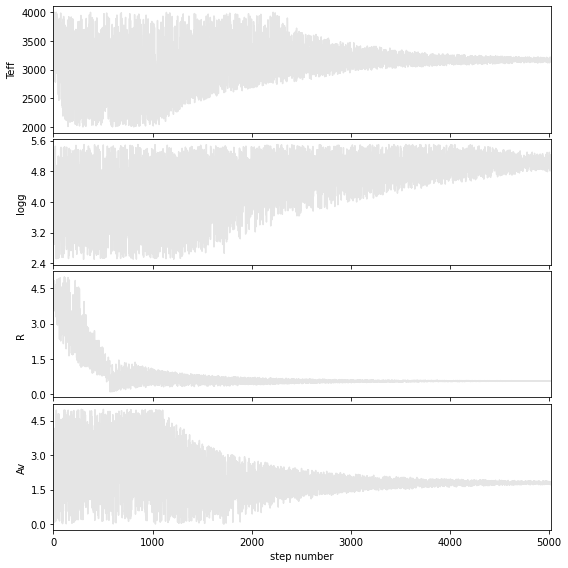


Walk plots after the burnin


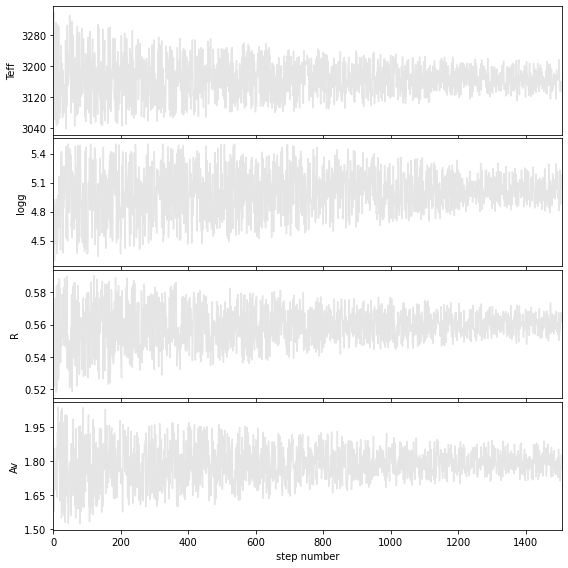


Weighted mean +- sqrt(covariance)
Teff = 3167 +/- 41
logg = 5.0 +/- 0.2
R = 0.56 +/- 0.01
Av = 1.8 +/- 0.1

Hist bins = 38


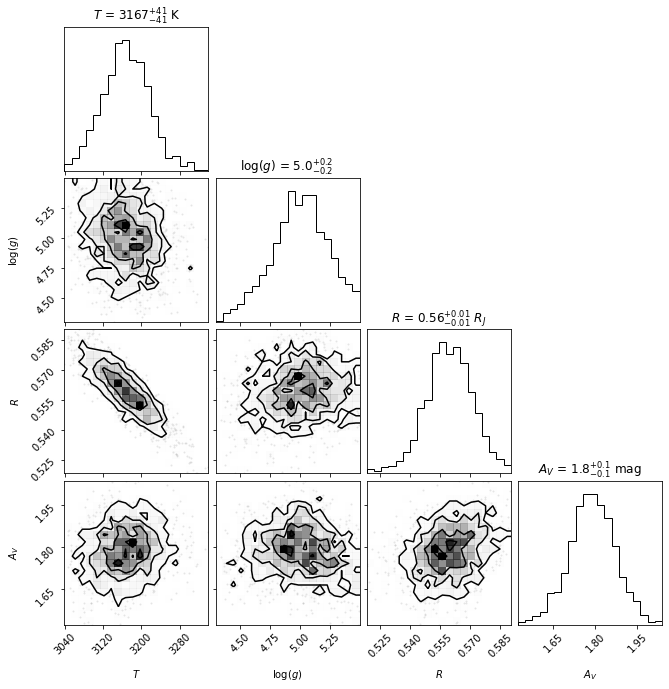


Confidence intervals
percentage for Teff: 71.03988615222444%
percentage for logg: 70.16908724949069%
percentage for R: 71.24274570813188%
percentage for Av: 68.70105333140197%
******* Results for Teff ***** 


Confidence intervals:
Teff: 3161.6627828480687 [-35.7040755894177,51.57255362915839]
Gaussian fit results:
Teff: 3167.2133663069158 +-48.57295195010271
******* Results for logg ***** 


Confidence intervals:
logg: 4.944004386713413 [-0.14284477072417623,0.3015611826399276]
Gaussian fit results:
logg: 4.999729389054955 +-0.23708440227459357
******* Results for R ***** 


Confidence intervals:
R: 0.5608581591700004 [-0.012324512563130718,0.00853235485139825]
Gaussian fit results:
R: 0.5592678467367134 +-0.011759030598860281
******* Results for Av ***** 


Confidence intervals:
Av: 1.8011659377215912 [-0.08813972568166073,0.061019810087303394]
Gaussian fit results:
Av: 1.7881925524990752 +-0.08199748042195355


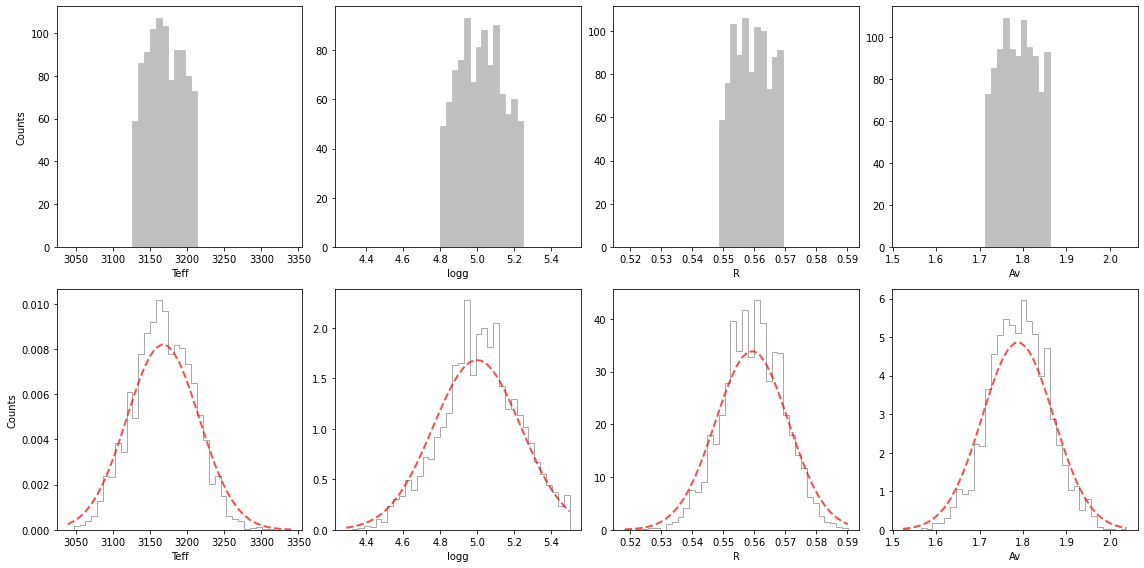

In [126]:
from special.nested_sampling import nested_sampling_results

final_res = nested_sampling_results(res, labels, burnin=0.7, bins=None, cfd=68.27,
                                    units=units, ndig=ndig, labels_plot=labels_plot, save=False, 
                                    output_dir='./', plot=True)

We see that for the case of the spectrum of CrA-9B/b with a BT-SETTL + extinction model, even when we allow for multiple nests, the highest likelihood area in the parameter space still corresponds to an individual ellipsoid.

# 7. Best-fit template spectrum

In this section, we will find the best-fit template spectra to our measured spectrum in the Montreal Spectral Library of observed M-L-T type low-mass objects. Since the template spectra from this library typically do not cover wavelengths longward of the K band, we will discard the NACO L' point from the spectrum, just for the sake of this exercise: 

In [127]:
lbda_crop = lbda[:-1]
spec_crop = spec[:-1]
spec_err_crop = spec_err[:-1]
dlbda_crop = dlbda[:-1]

Let's define the parameters associated to the instrument(s) which acquired the spectrum (again we discard the NACO measurement):

In [128]:
instru_fwhm_crop = instru_fwhm[:-1]
instru_idx_crop = instru_idx[:-1]
final_sp_corr_crop = final_sp_corr[:-1,:-1]

instru_params = {'instru_fwhm':instru_fwhm_crop,
                 'instru_idx':instru_idx_crop,
                 'instru_corr':final_sp_corr_crop,
                 'filter_reader':filter_reader}

For this exercice, we have downloaded the MSL library following the instructions on the page of J. Gagné: https://jgagneastro.com/the-montreal-spectral-library/

Below, we then set the folder in which the template spectra placed, and their extension ('.fits', for automatic identification of spectra in that folder). We also define the snippet function `tmp_reader` to read the template spectra in the utils.py file, loaded below.

In [129]:
from utils import tmp_reader
inpath_models = '../static/MSL/'
tmp_endswith='.fits'
tmp_params = {'tmp_reader':tmp_reader,
              'lib_dir':inpath_models,
              'tmp_endswith':tmp_endswith}

Let's assume we are interested in the top 3 most similar template spectra:

In [130]:
n_best=3

Let's use the Nelder-Mead algorithm to find the optimal flux scaling factor and $A_V$ to be applied to each template. Additional options for the simplex can be set with `simplex_options` (example above) - these will be provided to the `scipy.minimize` function. 

In [131]:
search_mode = 'simplex'
simplex_options = {'xatol': 1e-6, 'fatol': 1e-6, 'maxiter': 1000, 'maxfev': 5000}
AV_range = (-3, 7, 0.1) # min, max, step. Note: in simplex mode, min and max values are only used to set a chi=np.inf outside of these bounds.

search_opt = {'search_mode':search_mode,
              'simplex_options':simplex_options, 
              #'scale_range':(0.2, 5, 0.05),# min, max, step
              'ext_range':AV_range}

Alternatively, one can set `search_mode` to `'grid'`, which will simply use a grid search to find the optimal $A_V$ and flux scaling factors to be applied to the template spectra for comparison to the measured spectrum. This is slower but avoids the risk of a failed minimization. In this case, both the `AV_range` and `scale_range` parameters have to be set.

Some template spectra may be corrupted or unusable for this specific spectrum (e.g. wrong wavelength coverage), let's force the algorithm to continue instead of raising an error. Let's also discard any NaN points from the template spectra:

In [132]:
force_continue=True
remove_nan=True

Now let's find the best-fit templates:

In [133]:
from special.template_fit import best_fit_tmp

final_res = best_fit_tmp(lbda_crop, spec_crop, spec_err_crop, dlbda_obs=dlbda_crop, n_best=n_best, 
                         **tmp_params, **search_opt, **instru_params, force_continue=force_continue, 
                         remove_nan=remove_nan, verbosity=1)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-02-21 14:09:55
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2022-02-21 14:09:55
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
424 template spectra will be tested. 

****************************************

Nelder-Mead minimization is running...
opening 2MASSJ0428+1839_NIR_SpeX_Gagne2015c.fits
0/424: done in 0:00:00.394708s
Fit may take a total of ~3min 

Nelder-Mead minimization is running...
opening 2MASSJ0313-2447_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ2215+2110_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ2353-1844A_NIR_SpeX_Gagne2015c.fits


I_R_A_FNAME= 'J2353A_merge'       /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ1150+0520_NIR_NIRI_Robert2016.fits
Wavelength range of template SIMPJ1150+0520_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
4/424 (SIMPJ1150+0520_NIR_NIRI_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ2238+2304_NIR_SpeX_Robert2016.fits
No indices match the constraint (floor w.r.t 0.93)
Issue with resampling of template SIMPJ2238+2304_NIR_SpeX_Robert2016.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
5/424 (SIMPJ2238+2304_NIR_SpeX_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ1045-2819_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1501-1831_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ2251-6811_NIR_Flamingos-2_Gagne2015c.fits


I_R_A_FNAME= 'J2251-6811_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ0429+0607_NIR_GNIRS_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ1058+1339_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0752-7947_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0443+0002_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ2148+2239_NIR_NIRI_Robert2016.fits
Wavelength range of template SIMPJ2148+2239_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
13/424 (SIMPJ2148+2239_NIR_NIRI_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ2202-5605_NIR_Flamingos-2_Gagne2015c.fits


I_R_A_FNAME= 'J2202-5605_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ0951-1343_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ1119-3917_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1627+0836_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0344+0716B_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1510-1147_NIR_SpeX_Robert2016.fits
No indices match the constraint (floor w.r.t 0.93)
Issue with resampling of template SIMPJ1510-1147_NIR_SpeX_Robert2016.fits. Does the wavelength range extend far enough (0.94, 2.43)mu?
19/424 (SIMPJ1510-1147_NIR_SpeX_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ1415+2635_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ1613-0747_NIR_NIRI_Robert2016.fits
Wavelength range of template SIMPJ1613-0747_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)m

I_R_A_FNAME= 'J2240+0532_merge'   /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ2322-1407_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ1225-1013_NIR_GNIRS_Robert2016.fits
Wavelength range of template SIMPJ1225-1013_NIR_GNIRS_Robert2016.fits (1.00, 2.52)mu too short compared to that of observed spectrum (0.95, 2.25)mu
24/424 (SIMPJ1225-1013_NIR_GNIRS_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ2318-1301_NIR_SIMON_Robert2016.fits
No indices match the constraint (ceil w.r.t 2.31)
Issue with resampling of template SIMPJ2318-1301_NIR_SIMON_Robert2016.fits. Does the wavelength range extend far enough (0.80, 2.27)mu?
25/424 (SIMPJ2318-1301_NIR_SIMON_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ1217+0708_NIR_GNIRS_Robert2016.fits


/Users/valentin/GitHub/special/special/model_resampling.py:719: RuntimeWarning: invalid value encountered in multiply
  num = np.sum(interp_trans*dlbda_mod[idx_ini:idx_fin]*spec_mod[idx_ini:idx_fin])
/Users/valentin/opt/miniconda3/envs/spec_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


26/424 (SIMPJ1217+0708_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening SIMPJ0858+2710_NIR_GNIRS_Robert2016.fits
27/424 (SIMPJ0858+2710_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening 2MASSJ0120-5200_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ0150+3827_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0103-2805B_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0041-5621_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1756+2815_NIR_NIRI_Robert2016.fits
Wavelength range of template SIMPJ1756+2815_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
32/424 (SIMPJ1756+2815_NIR_NIRI_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ1031+3349_NIR_SpeX_Robert2016.fits
N

I_R_A_FNAME= 'J2041-3506_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ2219-6828_NIR_Flamingos-2_Gagne2015c.fits


I_R_A_FNAME= 'J22191486-6828018_ALLCOMB_merge' /                                 [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ1211+0406_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ0148+3712_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ1308+0818_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ0851+1043_NIR_GNIRS_Robert2016.fits
39/424 (SIMPJ0851+1043_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening 2MASSJ0226-5327_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0335+2342_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ2150-0412_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ1755+3618_NIR_NIRI_Robert2016.fits
Wavelength range of template SIMPJ1755+3618_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
43/424 (SIMPJ1755+3618_NIR_NIRI_Robert2016.fits) FAILED
Nelde

I_R_A_FNAME= 'J2244-3045_merge'   /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ1414+0107_NIR_NIRI_Robert2016.fits
Wavelength range of template SIMPJ1414+0107_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
49/424 (SIMPJ1414+0107_NIR_NIRI_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ0758+15301A_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0038-6403_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1058+1339_NIR_GNIRS_Robert2016.fits
52/424 (SIMPJ1058+1339_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening SIMPJ0429+0607_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ1411-2119_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0856-1342_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ1207-3900_NIR_SpeX_Gagne2015c.fits
N

I_R_A_FNAME= 'J2335-3401_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ0309-3014_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0019-6226_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0404+2616B_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ1547-1626B_NIR_SpeX_Gagne2015c.fits
No indices match the constraint (floor w.r.t 0.93)
Issue with resampling of template 2MASSJ1547-1626B_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
68/424 (2MASSJ1547-1626B_NIR_SpeX_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ1227-0636_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ1948+5944B_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ2011-5048_NIR_FIRE_Gagne2015c.fits


I_R_A_FNAME= 'W2011-5048_tc.fits' /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ0259-4232_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ1153-3015_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ2303+3150_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ1156-4043_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1211+0406_NIR_GNIRS_Robert2016.fits
76/424 (SIMPJ1211+0406_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening 2MASSJ1035-2058_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0314+1603_NIR_SpeX_Gagne2015c.fits
No indices match the constraint (floor w.r.t 0.93)
Issue with resampling of template 2MASSJ0314+1603_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
78/424 (2MASSJ0314+1603_NIR_SpeX_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
open

I_R_A_FNAME= 'J2244-6650_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ1039-1904_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ1133-7807_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ1207-3900_NIR_SpeX_Gagne2014b.fits
Nelder-Mead minimization is running...
opening SIMPJ0135+0205_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ0956-1447_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ2335-1908_NIR_SpeX_Gagne2015c.fits


I_R_A_FNAME= 'J2335-1908_merge'   /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ0819-0450_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1158+0435_NIR_SpeX_Robert2016.fits
Wavelength range of template SIMPJ1158+0435_NIR_SpeX_Robert2016.fits (1.13, 2.43)mu too short compared to that of observed spectrum (0.95, 2.25)mu
99/424 (SIMPJ1158+0435_NIR_SpeX_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ0002+0408A_NIR_SpeX_Gagne2015c.fits
2MASSJ0002+0408A_NIR_SpeX_Gagne2015c.fits could not be opened. Corrupt file?
100/424 (2MASSJ0002+0408A_NIR_SpeX_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ2343-3646_NIR_FIRE_Gagne2015c.fits


I_R_A_FNAME= 'W2343-3646_tc.fits' /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ0006-1319_NIR_GNIRS_Robert2016.fits
102/424 (SIMPJ0006-1319_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening SIMPJ0532-3253_NIR_GNIRS_Robert2016.fits
103/424 (SIMPJ0532-3253_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening 2MASSJ0148-5201_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ2028-5637_NIR_Flamingos-2_Gagne2015c.fits


I_R_A_FNAME= 'J2028-5637_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ0758+15300_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1324+1906_NIR_GNIRS_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ2235-5906_NIR_Flamingos-2_Gagne2015c.fits
Wavelength range of template 2MASSJ2235-5906_NIR_Flamingos-2_Gagne2015c.fits (0.89, 1.77)mu too short compared to that of observed spectrum (0.95, 2.25)mu
108/424 (2MASSJ2235-5906_NIR_Flamingos-2_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ0129-0823_NIR_Flamingos-2_Gagne2015c.fits


I_R_A_FNAME= 'J2235-5906_BEAMS_AB_140710_386_387_388_389_comb.fits' /            [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ0819-7401_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0537-0623_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1307-0558_NIR_GNIRS_Robert2016.fits
112/424 (SIMPJ1307-0558_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening 2MASSJ1207-3932_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1118-0856_NIR_NIRI_Robert2016.fits
Wavelength range of template SIMPJ1118-0856_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
114/424 (SIMPJ1118-0856_NIR_NIRI_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ1629+0335_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ0357+1529_NIR_GNIRS_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ0400-1322_NIR_GNIRS_Robert2016

I_R_A_FNAME= 'J20004841-7523070_ALLCOMB_merge' /                                 [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ2154-1055_NIR_SpeX_Gagne2015c.fits


I_R_A_FNAME= 'spc0070.a.fits'                                                    [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ0536-1920_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ0422+1033_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ1333-0215_NIR_SpeX_Robert2016.fits
Wavelength range of template SIMPJ1333-0215_NIR_SpeX_Robert2016.fits (1.13, 2.43)mu too short compared to that of observed spectrum (0.95, 2.25)mu
124/424 (SIMPJ1333-0215_NIR_SpeX_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ1452+1114_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ2310-0748_NIR_SpeX_Gagne2015c.fits


I_R_A_FNAME= 'J2310-0748_merge'   /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ0649-3823_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1613-0747_NIR_GNIRS_Robert2016.fits
128/424 (SIMPJ1613-0747_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening SIMPJ0552+0210_NIR_GNIRS_Robert2016.fits
129/424 (SIMPJ0552+0210_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening SIMPJ0417-1345_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0018-6703_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0300-5459_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ2315-4747_NIR_FIRE_Gagne2015c.fits


I_R_A_FNAME= 'W2315-4747_tc.fits' /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ0316+2650_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ1621-2346_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0320-3313_NIR_Flamingos-2_Gagne2015c.fits
Wavelength range of template 2MASSJ0320-3313_NIR_Flamingos-2_Gagne2015c.fits (1.00, 2.42)mu too short compared to that of observed spectrum (0.95, 2.25)mu
136/424 (2MASSJ0320-3313_NIR_Flamingos-2_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ1101-7735_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ2048-5127_NIR_Flamingos-2_Gagne2015c.fits


I_R_A_FNAME= 'W2048-5127_tc.fits' /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ1004-1127_NIR_GNIRS_Robert2016.fits
Wavelength range of template SIMPJ1004-1127_NIR_GNIRS_Robert2016.fits (1.00, 2.52)mu too short compared to that of observed spectrum (0.95, 2.25)mu
139/424 (SIMPJ1004-1127_NIR_GNIRS_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ0339-2434_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ1529+6312_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0355-1032_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ0414+1529_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ1257-4111_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ2048-3255_NIR_SpeX_Gagne2015c.fits
No indices match the constraint (floor w.r.t 0.93)
Issue with resampling of template 2MASSJ2048-3255_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far e

I_R_A_FNAME= 'J2048-3255_merge'   /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ2332-1249_NIR_SpeX_Robert2016.fits
SIMPJ2332-1249_NIR_SpeX_Robert2016.fits could not be opened. Corrupt file?
147/424 (SIMPJ2332-1249_NIR_SpeX_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ0635-6234_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ0008+0806_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ2327+3858_NIR_SpeX_Gagne2015c.fits


I_R_A_FNAME= 'J2327+3858_merge'   /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ1358-0046_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ2327+1517_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ0049+0440_NIR_GNIRS_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0825-0029_NIR_FIRE_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ2154-1055_NIR_SpeX_Gagne2014c.fits
Nelder-Mead minimization is running...
opening SIMPJ0006-1319_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0244-3548_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0342-2904_NIR_FIRE_Gagne2015c.fits
No indices match the constraint (ceil w.r.t 2.31)
Issue with resampling of template 2MASSJ0342-2904_NIR_FIRE_Gagne2015c.fits. Does the wavelength range extend far enough (0.83, 2.30)mu?
158/424 (2MASSJ0342-2904_NIR_FIRE_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening 

I_R_A_FNAME= 'J2149-6413_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ1039-2829_NIR_NIRI_Robert2016.fits
Wavelength range of template SIMPJ1039-2829_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
173/424 (SIMPJ1039-2829_NIR_NIRI_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ0820-7514_NIR_FIRE_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ2309+1003_NIR_GNIRS_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0805+2505B_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1613-0747_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0951+3558_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ2325-0259_NIR_SpeX_Gagne2015c.fits
No indices match the constraint (floor w.r.t 0.93)
Issue with resampling of template 2MASSJ2325-0259_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.

I_R_A_FNAME= 'J2325-0259'         /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ1623-2353_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening GUPscb_NIR_GNIRS_Naud2014.fits
No indices match the constraint (floor w.r.t 0.93)
Issue with resampling of template GUPscb_NIR_GNIRS_Naud2014.fits. Does the wavelength range extend far enough (0.94, 2.35)mu?
183/424 (GUPscb_NIR_GNIRS_Naud2014.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ1132-3809_NIR_NIRI_Robert2016.fits
Wavelength range of template SIMPJ1132-3809_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
184/424 (SIMPJ1132-3809_NIR_NIRI_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ0526-1824_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ1204-2806_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0540-0923_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
o

I_R_A_FNAME= 'J2112-8128_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ0013+0841_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ1939-5216_NIR_FIRE_Gagne2015c.fits


I_R_A_FNAME= 'W1939-5216_tc.fits' /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ2148-4736_NIR_Flamingos-2_Gagne2015c.fits


I_R_A_FNAME= 'J2148-4736_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ1117+1857_NIR_GNIRS_Robert2016.fits
193/424 (SIMPJ1117+1857_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening 2MASSJ0355+1133_NIR_SpeX_Gagne2015c.fits
No indices match the constraint (floor w.r.t 0.93)
Issue with resampling of template 2MASSJ0355+1133_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
194/424 (2MASSJ0355+1133_NIR_SpeX_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ2005-6258_NIR_Flamingos-2_Gagne2015c.fits


I_R_A_FNAME= 'J2005-6258_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ0211-1427_NIR_SpeX_Robert2016.fits
No indices match the constraint (floor w.r.t 0.93)
Issue with resampling of template SIMPJ0211-1427_NIR_SpeX_Robert2016.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
196/424 (SIMPJ0211-1427_NIR_SpeX_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ1041-0429_NIR_GNIRS_Robert2016.fits
197/424 (SIMPJ1041-0429_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening 2MASSJ0804-6346_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1343-1216_NIR_NIRI_Robert2016.fits
Wavelength range of template SIMPJ1343-1216_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
199/424 (SIMPJ1343-1216_NIR_NIRI_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ1903-3723_NIR_Flamingos-2_Gagne2015c.fits


I_R_A_FNAME= 'J1903-3723_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ1948+5944A_NIR_SpeX_Gagne2015c.fits


I_R_A_FNAME= 'J1948+5944A_merge'  /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ1846-5706_NIR_Flamingos-2_Gagne2015c.fits
Wavelength range of template 2MASSJ1846-5706_NIR_Flamingos-2_Gagne2015c.fits (0.90, 1.88)mu too short compared to that of observed spectrum (0.95, 2.25)mu
202/424 (2MASSJ1846-5706_NIR_Flamingos-2_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ0453-1751_NIR_SpeX_Gagne2015c.fits
No indices match the constraint (floor w.r.t 0.93)
Issue with resampling of template 2MASSJ0453-1751_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
203/424 (2MASSJ0453-1751_NIR_SpeX_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ2048-5127_NIR_FIRE_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1537-0800_NIR_GNIRS_Robert2016.fits
205/424 (SIMPJ1537-0800_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening SIMPJ2322-1407_NIR_NIRI_Robert2016.fits
Wave

I_R_A_F-TLM= '2013-07-18T21:19:33' / Time of last modification                   [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ0251-0818_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ1846+5246A_NIR_SpeX_Gagne2015c.fits


I_R_A_FNAME= 'J1846+5246_A_merge' /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ0039+1330A_NIR_SpeX_Gagne2015c.fits
2MASSJ0039+1330A_NIR_SpeX_Gagne2015c.fits could not be opened. Corrupt file?
227/424 (2MASSJ0039+1330A_NIR_SpeX_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ1257-3635_NIR_Flamingos-2_Gagne2015c.fits


I_R_A_FNAME= 'J12574463-3635431_ALLCOMB_merge' /                                 [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ1150+0520_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ1013-1706B_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1141+1941_NIR_GNIRS_Robert2016.fits
231/424 (SIMPJ1141+1941_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening SIMPJ1003-1441_NIR_SpeX_Robert2016.fits
No indices match the constraint (floor w.r.t 0.93)
Issue with resampling of template SIMPJ1003-1441_NIR_SpeX_Robert2016.fits. Does the wavelength range extend far enough (0.94, 2.43)mu?
232/424 (SIMPJ1003-1441_NIR_SpeX_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ1631-1922_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ2235-3844_NIR_Flamingos-2_Gagne2015c.fits


I_R_A_FNAME= 'J2235-3844_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ0326-0617_NIR_SpeX_Gagne2015c.fits
No indices match the constraint (floor w.r.t 0.93)
Issue with resampling of template 2MASSJ0326-0617_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
235/424 (2MASSJ0326-0617_NIR_SpeX_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ0518-3101_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1422+0827_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ2331-0406_NIR_Flamingos-2_Gagne2015c.fits
2MASSJ2331-0406_NIR_Flamingos-2_Gagne2015c.fits could not be opened. Corrupt file?
238/424 (2MASSJ2331-0406_NIR_Flamingos-2_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ1339+1523_NIR_SIMON_Robert2016.fits


    Header size is not multiple of 2880: 11366
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


Nelder-Mead minimization is running...
opening 2MASSJ1226-3316_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1615+1340_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0758+15301B_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ1247-3816_NIR_SpeX_Gagne2014b.fits
Nelder-Mead minimization is running...
opening SIMPJ0026-0936_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ1005+1703_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0017-3219_NIR_Flamingos-2_Gagne2015c.fits
2MASSJ0017-3219_NIR_Flamingos-2_Gagne2015c.fits could not be opened. Corrupt file?
246/424 (2MASSJ0017-3219_NIR_Flamingos-2_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ1318-0632_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0945-7753_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
openin

I_R_A_FNAME= 'J19350976-6200473_ALLCOMB_merge' /                                 [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ2344+0909_NIR_GNIRS_Robert2016.fits
SIMPJ2344+0909_NIR_GNIRS_Robert2016.fits could not be opened. Corrupt file?
261/424 (SIMPJ2344+0909_NIR_GNIRS_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ2202-1109_NIR_SpeX_Gagne2015c.fits


I_R_A_FNAME= 'J2202-1109_merge'   /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ0103-2805A_NIR_SpeX_Gagne2015c.fits
2MASSJ0103-2805A_NIR_SpeX_Gagne2015c.fits could not be opened. Corrupt file?
263/424 (2MASSJ0103-2805A_NIR_SpeX_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ0019+4614_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1537-0800_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ0858+2214_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ1654+3747_NIR_SpeX_Robert2016.fits
No indices match the constraint (floor w.r.t 0.93)
Issue with resampling of template SIMPJ1654+3747_NIR_SpeX_Robert2016.fits. Does the wavelength range extend far enough (0.94, 2.43)mu?
267/424 (SIMPJ1654+3747_NIR_SpeX_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ1044+0620_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0210-3015_NIR_Flamingos-2_Gagne2015c.fit

I_R_A_FNAME= 'J2336-3541_BEAMS_AB_140710_397_398_399_400_comb.fits' /            [astropy.io.fits.card]


274/424 (SIMPJ1036+0306_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening 2MASSJ2033-3733_NIR_Flamingos-2_Gagne2015c.fits


I_R_A_FNAME= 'J2033-3733_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ1256-2718_NIR_FIRE_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1052+1722_NIR_GNIRS_Robert2016.fits
277/424 (SIMPJ1052+1722_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening SIMPJ1605+1931_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0058-0651_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0708-4701_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ0423+1212_NIR_GNIRS_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ0422+0723_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ2033-5635_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ2114-4339_NIR_SpeX_Gagne2015c.fits


I_R_A_FNAME= 'J2114-4339_merge'   /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ0915+0514_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ2050-3639_NIR_Flamingos-2_Gagne2015c.fits


I_R_A_FNAME= 'J20505221-3639552_ALLCOMB_merge' /                                 [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ2304+0749_NIR_GNIRS_Robert2016.fits
287/424 (SIMPJ2304+0749_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening SIMPJ0136+0933_NIR_GNIRS_Robert2016.fits
288/424 (SIMPJ0136+0933_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening 2MASSJ0034-4102_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1627+0546_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ0013-1816_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ2330+1006_NIR_GNIRS_Robert2016.fits
292/424 (SIMPJ2330+1006_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening 2MASSJ2322-6151A_NIR_Flamingos-2_Gagne2015c.fits


I_R_A_FNAME= 'J2322-6151_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ1138+0748_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0548-2942_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ1622-2346_NIR_SpeX_Gagne2015c.fits
No indices match the constraint (floor w.r.t 0.93)
Issue with resampling of template 2MASSJ1622-2346_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
296/424 (2MASSJ1622-2346_NIR_SpeX_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ1343+1312_NIR_GNIRS_Robert2016.fits
297/424 (SIMPJ1343+1312_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening SIMPJ0006-2158_NIR_NIRI_Robert2016.fits
Wavelength range of template SIMPJ0006-2158_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
298/424 (SIMPJ0006-2158_NIR_NIRI_Robert2016.fits) FAILED
Nelder-Mead minimization is

I_R_A_FNAME= 'J2329_tell.fits'    /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ0540-0906_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening DENISJ0817-6155_NIR_OSIRIS_Artigau2010.fits
Wavelength range of template DENISJ0817-6155_NIR_OSIRIS_Artigau2010.fits (1.13, 2.36)mu too short compared to that of observed spectrum (0.95, 2.25)mu
304/424 (DENISJ0817-6155_NIR_OSIRIS_Artigau2010.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ0228+0218_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ1051-1916_NIR_SpeX_Gagne2015c.fits
No indices match the constraint (floor w.r.t 0.93)
Issue with resampling of template 2MASSJ1051-1916_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
306/424 (2MASSJ1051-1916_NIR_SpeX_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ2351+3010_NIR_SpeX_Robert2016.fits
SIMPJ2351+3010_NIR_SpeX_Robert2016.fits could not be opened. Corrupt file?
307/424 (SIM

I_R_A_FNAME= 'J1839+2952_merge'   /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ2002-1316_NIR_SpeX_Gagne2015c.fits
No indices match the constraint (floor w.r.t 0.93)
Issue with resampling of template 2MASSJ2002-1316_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
315/424 (2MASSJ2002-1316_NIR_SpeX_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ1147-1032_NIR_GNIRS_Robert2016.fits


I_R_A_FNAME= 'J2002-1316_merge'   /                                              [astropy.io.fits.card]


316/424 (SIMPJ1147-1032_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening SIMPJ1039+2440_NIR_NIRI_Robert2016.fits
Wavelength range of template SIMPJ1039+2440_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
317/424 (SIMPJ1039+2440_NIR_NIRI_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ0344+0716A_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ0004-2007_NIR_NIRI_Robert2016.fits
Wavelength range of template SIMPJ0004-2007_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
319/424 (SIMPJ0004-2007_NIR_NIRI_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ0336-2619_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ0946+1808_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0545-0121_NIR_F

I_R_A_FNAME= 'J2039-1126_merge'   /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ0803+0827_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ2157-0130_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0805+2505A_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1256-1002_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ1118-0856_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ2313-6127_NIR_Flamingos-2_Gagne2015c.fits


I_R_A_FNAME= 'J2313-6127_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ0410+1459_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ1009+1559_NIR_GNIRS_Robert2016.fits
342/424 (SIMPJ1009+1559_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening SIMPJ2213+1255_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0027-0806_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0507+1430B_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ0138-0322_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ0155+0950_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ1252-3415_NIR_GNIRS_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0153-6744_NIR_FIRE_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ2322-6151B_NIR_Flamingos-2_Gagne2015c.fits


I_R_A_FNAME= 'J2322-6151B_ALLCOMB_merge' /                                       [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ1811+2728_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ1627-2411_NIR_GNIRS_Gagne2015c.fits


I_R_A_F-TLM= '2013-07-18T20:09:23' / Time of last modification                   [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ0021-4244_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ2206-6116_NIR_FIRE_Gagne2015c.fits


I_R_A_FNAME= 'W2206-6116_tc.fits' /                                              [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ2255-0725_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ1455+2619_NIR_SpeX_Robert2016.fits
No indices match the constraint (floor w.r.t 0.93)
Issue with resampling of template SIMPJ1455+2619_NIR_SpeX_Robert2016.fits. Does the wavelength range extend far enough (0.94, 2.43)mu?
356/424 (SIMPJ1455+2619_NIR_SpeX_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ0258-1520_NIR_FIRE_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1127+1234_NIR_GNIRS_Robert2016.fits
358/424 (SIMPJ1127+1234_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening SIMPJ1756+3343_NIR_NIRI_Robert2016.fits
Wavelength range of template SIMPJ1756+3343_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
359/424 (SIMPJ1756+3343_NIR_NIRI_Robert2016.fits) FAILED
Nelder-Mead minimization is ru

I_R_A_FNAME= 'J2257-5041_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ1301-1510_NIR_SpeX_Gagne2015c.fits
No indices match the constraint (floor w.r.t 0.93)
Issue with resampling of template 2MASSJ1301-1510_NIR_SpeX_Gagne2015c.fits. Does the wavelength range extend far enough (0.95, 2.42)mu?
362/424 (2MASSJ1301-1510_NIR_SpeX_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ1130+2341_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ0357-1937_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ2154-7459_NIR_Flamingos-2_Gagne2015c.fits
No indices match the constraint (floor w.r.t 0.93)
Issue with resampling of template 2MASSJ2154-7459_NIR_Flamingos-2_Gagne2015c.fits. Does the wavelength range extend far enough (0.94, 2.42)mu?
365/424 (2MASSJ2154-7459_NIR_Flamingos-2_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ2206-4217_NIR_SpeX_Gagne2015c.fits


I_R_A_FNAME= 'J2154-7459_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ1143+1905_NIR_NIRI_Robert2016.fits
Wavelength range of template SIMPJ1143+1905_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
367/424 (SIMPJ1143+1905_NIR_NIRI_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ2315+2235_NIR_NIRI_Robert2016.fits
Wavelength range of template SIMPJ2315+2235_NIR_NIRI_Robert2016.fits (0.98, 2.45)mu too short compared to that of observed spectrum (0.95, 2.25)mu
368/424 (SIMPJ2315+2235_NIR_NIRI_Robert2016.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ2248-0126_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ1542-3358_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ0432-0639_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ1644+2600_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0006-6436

I_R_A_FNAME= 'J2038-4118_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening SIMPJ1013-1946_NIR_GNIRS_Robert2016.fits
385/424 (SIMPJ1013-1946_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening 2MASSJ2314-5405_NIR_Flamingos-2_Gagne2015c.fits


I_R_A_FNAME= 'J2314-5405_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ0440-1820_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1108+0838_NIR_GNIRS_Robert2016.fits
388/424 (SIMPJ1108+0838_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening 2MASSJ0004-1709_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ1325+0600_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ2235+0418_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0017-0316_NIR_SpeX_Gagne2015c.fits
2MASSJ0017-0316_NIR_SpeX_Gagne2015c.fits could not be opened. Corrupt file?
392/424 (2MASSJ0017-0316_NIR_SpeX_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening SIMPJ0421-1950_NIR_GNIRS_Robert2016.fits
393/424 (SIMPJ0421-1950_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening 2MASSJ0417-1140_NIR

I_R_A_FNAME= 'J2134-1840_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ1253-4211_NIR_Flamingos-2_Gagne2015c.fits
Wavelength range of template 2MASSJ1253-4211_NIR_Flamingos-2_Gagne2015c.fits (0.90, 1.75)mu too short compared to that of observed spectrum (0.95, 2.25)mu
397/424 (2MASSJ1253-4211_NIR_Flamingos-2_Gagne2015c.fits) FAILED
Nelder-Mead minimization is running...
opening 2MASSJ1633-2425_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1102+1629_NIR_GNIRS_Robert2016.fits
399/424 (SIMPJ1102+1629_NIR_GNIRS_Robert2016.fits) FAILED (simplex did not converge)
Nelder-Mead minimization is running...
opening SIMPJ0945-0757_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening SIMPJ2322+1300_NIR_SIMON_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0318-3708_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening SIMPJ1343-1216_NIR_SpeX_Robert2016.fits
Nelder-Mead minimization is running...
opening 2MASSJ0527+0007A_NIR

I_R_A_FNAME= 'J2022-5645_ALLCOMB_merge' /                                        [astropy.io.fits.card]


Nelder-Mead minimization is running...
opening 2MASSJ1247-3816_NIR_SpeX_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0418-4507_NIR_Flamingos-2_Gagne2015c.fits
Nelder-Mead minimization is running...
opening 2MASSJ0423-1533_NIR_Flamingos-2_Gagne2015c.fits
****************************************

308/424 template spectra were fitted. 

Running time:  0:07:16.793058
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
best chi:  [2.88768921 2.99549636 3.20434253]
best scale fac:  [0.02401384 0.0112894  0.01819982]
n_dof:  [39. 39. 39.]
The best template #1 is: 2MASSJ0507+1430B_NIR_SpeX_Gagne2015c.fits (Delta A_V=1.7mag)

The best template #2 is: GUPscA_NIR_SpeX_Naud2014.fits (Delta A_V=2.2mag)

The best template #3 is: 2MASSJ0339-2434_NIR_SpeX_Gagne2015c.fits (Delta A_V=2.0mag)



Let's load the results, and prepare a list of short template names (for display; i.e. without the suffix):

In [134]:
final_tmpname, final_tmp, final_chi, final_params, _ = final_res

n_end = len(tmp_endswith) 
short_tmpname = [final_tmpname[i][:-n_end] for i in range(len(final_tmpname))]
short_tmpname

['2MASSJ0507+1430B_NIR_SpeX_Gagne2015c',
 'GUPscA_NIR_SpeX_Naud2014',
 '2MASSJ0339-2434_NIR_SpeX_Gagne2015c']

Checking in the [online table of the MSL](https://docs.google.com/spreadsheets/d/1136rRdcjHZJoe00mt4kPeWU8ZNORcPe-w4cipkDKGRc/edit#gid=0), these spectra turn out to correspond to the following types of objects:

In [135]:
labels_tmp = ["young M5.5", "young M3", "young M5"] 

Let's finally plot the best-fit template spectra, at native resolution and resampled, respectively:

Fits HDU-0 data and header successfully loaded. Data shape: (3, 4110)
Fits HDU-0 data and header successfully loaded. Data shape: (3, 4166)
Fits HDU-0 data and header successfully loaded. Data shape: (3, 4169)


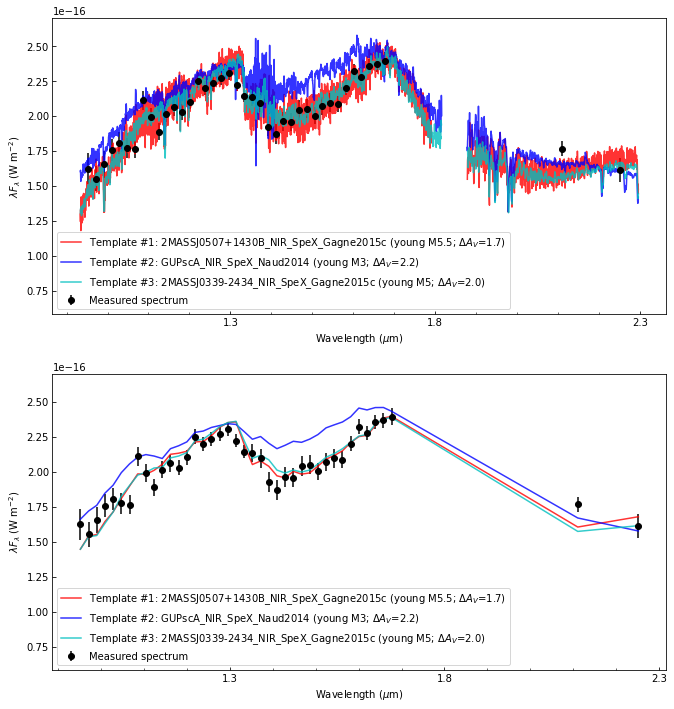

In [136]:
import importlib
importlib.reload(special.model_resampling)
from special.model_resampling import resample_model

# Prepare plot
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(11,12))

ax1.set_xlabel(r"Wavelength ($\mu$m)")
ax1.set_ylabel("$\lambda F_{\lambda}$ (W m$^{-2}$)")
ax1.set_ylim(0.8*np.amin(lbda*(spec+spec_err)),
             1.1*np.amax(lbda*(spec+spec_err)))

ax2.set_xlabel(r"Wavelength ($\mu$m)")
ax2.set_ylabel("$\lambda F_{\lambda}$ (W m$^{-2}$)")
ax2.set_ylim(0.8*np.amin(lbda*(spec+spec_err)),
             1.1*np.amax(lbda*(spec+spec_err)))

# plot options
cols = ['k', 'r', 'b', 'c', 'y', 'm'] # colors of different models
maj_tick_sp = 0.5 # WL spacing for major ticks
min_tick_sp = maj_tick_sp / 5. # WL spacing for minor ticks

# Plot of top 3 spectra:
counter = 0
object_list = []
for ll in range(n_best):
    ## loading
    try:
        _, header = open_fits(inpath_models+final_tmpname[ll],header=True)
        object_list.append(header['OBJECT'])
    except KeyError:
        object_list.append(short_tmpname[ll])
    lbda_tmp, flux_tmp, flux_tmp_err = final_tmp[ll]

    ## cropping range
    try:
        idx_ini = find_nearest(lbda_tmp,0.98*lbda_crop[0], constraint='floor')
    except:
        idx_ini = 0
    try:
        idx_fin = find_nearest(lbda_tmp,1.02*lbda_crop[-1], constraint='ceil')
    except:
        idx_fin = -1
    lbda_tmp_crop = lbda_tmp[idx_ini:idx_fin]
    flux_tmp_crop = flux_tmp[idx_ini:idx_fin]
    dlbda_tmp = np.mean(lbda_tmp_crop[1:]-lbda_tmp_crop[:-1])

    ## Convolving + resampling template spectrum 
    ### only consider non-zero and non-nan values
    cond1 = np.where(np.isfinite(flux_tmp))[0]
    cond2 = np.where(np.isfinite(flux_tmp_err))[0] 
    cond3 = np.where(flux_tmp>0)[0]
    all_conds = np.sort(np.unique(np.concatenate((cond1,cond2,cond3))))
    ngood_ch = len(all_conds)
    good_ch = (all_conds,)
    lbda_tmp = lbda_tmp[good_ch]
    flux_tmp = flux_tmp[good_ch]
    flux_tmp_err = flux_tmp_err[good_ch]
    tmp_res = resample_model(lbda_crop, lbda_tmp, flux_tmp, 
                             dlbda_obs=dlbda_crop, 
                             instru_fwhm=instru_fwhm_crop, 
                             instru_idx=instru_idx_crop, 
                             filter_reader=filter_reader)
    lbda_tmp_res, flux_tmp_res = tmp_res
                
    ## formatting labels
    lab_str_list = [labels_tmp[ll]]
    if AV_range is not None:
        lab_str = r'$\Delta A_V$={0:.{1}f}{2}'.format(final_params[1][ll],ndig[1],units[1])
        lab_str_list.append(lab_str)
    sep = '; '
    if n_best>1:
        label = "Template #{:.0f}: {} ({})".format(ll+1, short_tmpname[ll], #labels_tmp[ll], 
                                                   sep.join(lab_str_list))
    else:
        label = "Best template: {} ({})".format(short_tmpname[ll], #labels_tmp[ll], 
                                                sep.join(lab_str_list))
        
    ## plotting
    ax1.plot(lbda_tmp_crop, lbda_tmp_crop*flux_tmp_crop, cols[ll+1],
             alpha=0.8, label=label)
    ax2.plot(lbda_tmp_res, lbda_tmp_res*flux_tmp_res, cols[ll+1],
             alpha=0.8, label=label)

    ## ticks
    min_tick = lbda_crop[0]-dlbda_crop[0]/2-((lbda_crop[0]-dlbda_crop[0]/2)%0.2)
    max_tick = lbda_crop[-1]+dlbda_crop[-1]/2+(0.2-((lbda_crop[-1]+dlbda_crop[-1]/2)%0.2))
    major_ticks1 = np.arange(min_tick,max_tick,maj_tick_sp)
    minor_ticks1 = np.arange(min_tick,max_tick,min_tick_sp)

    ax1.set_xticks(major_ticks1)
    ax1.set_xticks(minor_ticks1, minor = True)
    ax1.tick_params(which = 'both', direction = 'in')
    ax2.set_xticks(major_ticks1)
    ax2.set_xticks(minor_ticks1, minor = True)
    ax2.tick_params(which = 'both', direction = 'in')           

# Plot measured spectrum
ax1.errorbar(lbda_crop, lbda_crop*spec_crop, 
             lbda_crop*spec_err_crop, fmt=cols[0]+'o', 
             label='Measured spectrum')
ax1.legend(loc='best')
ax2.errorbar(lbda_crop, lbda_crop*spec_crop, 
             lbda_crop*spec_err_crop, fmt=cols[0]+'o', 
             label='Measured spectrum')
ax2.legend(loc='best')
    
plt.show()

[Go to the top](#Table-of-contents)